# Abstract

### The problem and challenge

Dengue fever is a mosquito-borne tropical disease caused by the dengue virus. Symptoms may include a high fever, headache, vomiting, muscle and joint pains, and a characteristic skin rash. In a small proportion of cases, the disease develops into severe dengue, also known as dengue hemorrhagic fever, resulting in bleeding, low levels of blood platelets and blood plasma leakage, or into dengue shock syndrome, where dangerously low blood pressure occurs.(https://en.wikipedia.org/wiki/Dengue_fever)

Each year, up to 400 million people get infected with dengue. Approximately 100 million people get sick from infection, and 22,000 die from severe dengue (https://www.cdc.gov/dengue/about/index.html). Accurate dengue predictions would help public health workers ... and people around the world take steps to reduce the impact of these epidemics. But predicting dengue is a hefty task that calls for the consolidation of different data sets on disease incidence, weather, and the environment. (https://obamawhitehouse.archives.gov/blog/2015/06/05/back-future-using-historical-dengue-data-predict-next-epidemic)

Because Dengue Fever is spread by female mosquitos, an increase in mosquito population precedes an increase in reported cases of infection. The goal of this project was to use historical weather and environmental data to see how accurately a machine learning model could predict the number of cases of Dengue Fever in two cities, San Juan, Puerto Rico and Iquitos, Peru.

### Methodology
This project followed the OSEMN protocol (Obtain, Scrub, Explore, Model, iNterpret). Data was obtained from the U.S. National Oceanic and Atmospheric Administration (NOAA) (https://dengueforecasting.noaa.gov/) and from Dark Sky* via their api (https://darksky.net/dev). The Keras and Tensorflow libraries were utilized to train machine learning models and tested for performance using the mean absolute error metric.  

### Results
For San Juan, the best performing model utilized only the data from the NOAA dataset from 1990 to 2005 and made predictions for total Dengue Fever cases for 2006 to early 2008. The approximate mean validation loss achieved was 0.0153.

For Iquitos, the best performing model utilized data from both NOAA and Dark Sky, from mid-2000 to mid-2008 and made predictions for mid-2008 to mid-2009. The approximate mean validation loss achieved was 0.0261.

### Potential further work
Some strategies that could be employed to see if the performance could be enhanced include:
* Use the minimum or maximum, instead of the mean, when calculating weekly values from the daily DarkSky data.
* Differencing the data by taking each weeks values and subtracting from the prior weeks values.
* Test other machine learning models designed for time series data.
* Multicollinearity is very present in the weather data. Many factors could be removed to eliminate multicollinearity to see if the models' performance can be improved.
* Because adding a dropout layer improved performance substantially, establishing limits to the maximum weights allowable in the model may also improve performance when predicting on new data.

### Author Information
Giovanni Rosati, giovanni.rosati@gmail.com

GitHub Repository: https://github.com/giorosati/dsc-5-capstone-project-online-ds-pt-100118

*Powered by Dark Sky (https://darksky.net/poweredby/)

# Imports

In [1]:
# imports

# misc
import datetime
import math
import os, sys, shutil
from collections import defaultdict
# from tqdm import tqdm

# basics
import numpy as np
from numpy import loadtxt
import pandas as pd
from pandas.plotting import autocorrelation_plot

# from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# charting
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline 

# for darksky api
import json
from pandas.io.json import json_normalize
import requests


Using TensorFlow backend.


# Code needed to load the data from DrivenData

In [2]:
# load the data
df_train = pd.read_csv('source_data/dengue_features_train.csv') 

In [3]:
df_train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [4]:
df_train.tail()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,iq,2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [5]:
train_labels = pd.read_csv('source_data/dengue_labels_train.csv')

In [6]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [7]:
train_labels['year'].unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])

In [8]:
df_train.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

In [10]:
# try making a new column instead
df_train['week_start_temp'] = pd.to_datetime(df_train['week_start_date'])

In [11]:
df_train['week_start_temp'].head()

0   1990-04-30
1   1990-05-07
2   1990-05-14
3   1990-05-21
4   1990-05-28
Name: week_start_temp, dtype: datetime64[ns]

In [12]:
df_train['week_start_temp'].tail()

1451   2010-05-28
1452   2010-06-04
1453   2010-06-11
1454   2010-06-18
1455   2010-06-25
Name: week_start_temp, dtype: datetime64[ns]

In [13]:
# drop old week_start_date
df_train = df_train.drop('week_start_date', axis = 1)

In [14]:
# rename week_start_temp
df_train.rename(columns={'week_start_temp': 'week_start_date'}, inplace=True)


In [15]:
# rearrange the columns
cols = df_train.columns.to_list()
cols = cols[-1:] + cols[:-1]


In [16]:
df_train = df_train[cols]


In [17]:
df_train.head()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [18]:
df_train.tail()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1451,2010-05-28,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,2010-06-04,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,2010-06-11,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,2010-06-18,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,2010-06-25,iq,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [19]:
# df_sj = df_train[df_train['city'] == 'sj']  #this creates a slice of the dataframe, not a new dataframe
# df_iq = df_train[df_train['city'] == 'iq']  #this creates a slice of the dataframe, not a new dataframe

In [20]:
# make seperate training dataframes for each city
df_sj = df_train.copy()
df_iq = df_train.copy()

In [21]:
df_sj.drop(df_sj[df_sj['city'] != 'sj'].index, inplace=True)
df_iq.drop(df_iq[df_iq['city'] != 'iq'].index, inplace=True)


In [22]:
# make seperate training labels dateframes for each city
sj_train_labels = train_labels.copy()
iq_train_labels = train_labels.copy()

sj_train_labels.drop(sj_train_labels[sj_train_labels['city'] != 'sj'].index, inplace=True)
iq_train_labels.drop(iq_train_labels[iq_train_labels['city'] != 'iq'].index, inplace=True)

In [23]:

sj_train_labels = sj_train_labels.drop('city', axis = 1)
iq_train_labels = iq_train_labels.drop('city', axis = 1)

In [24]:
sj_train_labels.tail()

,year,weekofyear,total_cases
931,2008,13,4
932,2008,14,3
933,2008,15,1
934,2008,16,3
935,2008,17,5


In [25]:
iq_train_labels.head()

,year,weekofyear,total_cases
936,2000,26,0
937,2000,27,0
938,2000,28,0
939,2000,29,0
940,2000,30,0


In [26]:
df_sj.tail()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
931,2008-03-25,sj,2008,13,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
932,2008-04-01,sj,2008,14,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
933,2008-04-08,sj,2008,15,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7
934,2008-04-15,sj,2008,16,0.00180,NaN,0.203900,0.209843,0.00,297.630000,...,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2
935,2008-04-22,sj,2008,17,-0.03700,-0.010367,0.077314,0.090586,0.00,298.672857,...,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3


In [27]:
df_iq.head()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0


In [28]:
print("sj length: {}".format(len(df_sj)))
print("iq length: {}".format(len(df_iq)))

sj length: 936
iq length: 520


In [29]:
# https://www.pythonprogramming.in/get-the-day-of-week-from-given-a-date-in-python.html
# Python's program to get the day of week of today or given date.
 
# dayofweek = datetime.date(2010, 6, 16).strftime("%A")
# print(dayofweek)
# # weekday Monday is 0 and Sunday is 6
# print("weekday():", datetime.date(2010, 6, 16).weekday())
 
# # isoweekday() Monday is 1 and Sunday is 7
# print("isoweekday()", datetime.date(2010, 6, 16).isoweekday())
 
# dayofweek = datetime.datetime.today().strftime("%A")
# print(dayofweek)
# print("weekday():", datetime.datetime.today().weekday())
# print("isoweekday()", datetime.datetime.today().isoweekday())

In [30]:
df_sj['week_start_date'].head(10)

0   1990-04-30
1   1990-05-07
2   1990-05-14
3   1990-05-21
4   1990-05-28
5   1990-06-04
6   1990-06-11
7   1990-06-18
8   1990-06-25
9   1990-07-02
Name: week_start_date, dtype: datetime64[ns]

In [31]:
df_sj.tail(10)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
926,2008-02-19,sj,2008,8,-0.13865,-0.095067,0.246057,0.228129,0.00,297.907143,...,8.30,74.785714,0.00,14.538571,1.885714,24.900000,5.785714,28.3,21.7,13.3
927,2008-02-26,sj,2008,9,NaN,0.015420,0.211629,0.117343,0.00,297.765714,...,6.46,72.660000,0.00,13.967143,2.285714,24.742857,5.500000,27.8,21.1,12.9
928,2008-03-04,sj,2008,10,-0.08890,-0.090033,0.223243,0.154186,0.00,297.878571,...,6.50,74.681429,0.00,14.474286,2.614286,25.114286,6.114286,29.4,21.1,13.0
929,2008-03-11,sj,2008,11,-0.32140,-0.141200,0.110643,0.141014,0.00,297.595714,...,9.38,71.934286,0.00,13.721429,2.085714,25.328571,5.814286,28.9,22.2,4.4
930,2008-03-18,sj,2008,12,0.04490,0.024450,0.101629,0.088000,0.00,297.404286,...,0.90,72.915714,0.00,13.737143,3.871429,25.200000,7.042857,30.0,20.6,0.5
931,2008-03-25,sj,2008,13,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8
932,2008-04-01,sj,2008,14,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,...,3.67,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5
933,2008-04-08,sj,2008,15,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,...,35.00,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7
934,2008-04-15,sj,2008,16,0.00180,NaN,0.203900,0.209843,0.00,297.630000,...,4.82,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2
935,2008-04-22,sj,2008,17,-0.03700,-0.010367,0.077314,0.090586,0.00,298.672857,...,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3


In [32]:
df_iq.head(10)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
936,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
937,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
938,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
939,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
940,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0
941,2000-08-05,iq,2000,31,0.205529,0.190757,0.231671,0.255314,16.24,297.191429,...,1.00,74.728571,16.24,13.421429,13.771429,25.340000,10.940000,32.0,17.0,11.5
942,2000-08-12,iq,2000,32,0.312486,0.329986,0.380586,0.387271,89.37,297.320000,...,26.68,83.275714,89.37,15.311429,11.471429,27.016667,11.650000,34.0,19.9,72.9
943,2000-08-19,iq,2000,33,0.384133,0.392240,0.341780,0.382750,42.08,297.627143,...,16.90,82.490000,42.08,15.465714,13.700000,26.583333,10.316667,33.0,20.5,50.1
944,2000-08-26,iq,2000,34,0.408157,0.322157,0.406714,0.302714,49.22,298.238571,...,5.59,74.740000,49.22,14.444286,13.771429,26.900000,13.400000,34.0,19.0,89.2
945,2000-09-02,iq,2000,35,0.332043,0.321057,0.314614,0.324257,53.65,299.218571,...,16.07,74.151429,53.65,15.057143,12.457143,27.116667,12.266667,34.0,20.0,78.0


In [33]:
df_iq.tail(10)

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1446,2010-04-23,iq,2010,16,0.231486,0.294686,0.331657,0.244400,86.70,298.438571,...,81.40,95.995714,86.70,19.448571,7.757143,27.850000,9.600000,33.5,22.5,51.1
1447,2010-04-30,iq,2010,17,0.239743,0.259271,0.307786,0.307943,26.00,299.048571,...,23.60,87.657143,26.00,18.068571,8.257143,28.850000,12.125000,36.2,21.4,35.4
1448,2010-05-07,iq,2010,18,0.260814,0.255786,0.257771,0.340286,73.97,297.617143,...,85.46,96.712857,73.97,18.602857,5.714286,27.600000,9.600000,33.2,21.4,8.1
1449,2010-05-14,iq,2010,19,0.168686,0.158500,0.133071,0.145600,59.40,297.278571,...,87.30,97.445714,59.40,18.391429,6.185714,27.400000,10.400000,33.7,21.2,32.0
1450,2010-05-21,iq,2010,20,0.263071,0.272500,0.258271,0.244500,1.15,297.648571,...,8.80,78.998571,1.15,14.908571,11.242857,25.633333,9.200000,34.0,20.0,2.5
1451,2010-05-28,iq,2010,21,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,2010-06-04,iq,2010,22,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,2010-06-11,iq,2010,23,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,2010-06-18,iq,2010,24,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0
1455,2010-06-25,iq,2010,25,0.298186,0.232971,0.274214,0.315757,63.22,298.097143,...,36.90,89.082857,63.22,17.355714,11.014286,27.475000,9.900000,33.7,22.2,20.4


In [34]:
sj_start_week = df_sj['weekofyear'][df_sj['year'] == 1990]
sj_end_week = df_sj['weekofyear'][df_sj['year'] == 2008]

iq_start_week = df_iq['weekofyear'][df_iq['year'] == 2000]
iq_end_week = df_iq['weekofyear'][df_iq['year'] == 2010]

In [35]:
# how many weeks in Iquitos dataset?
iq_start_week.describe()

count    26.000000
mean     38.500000
std       7.648529
min      26.000000
25%      32.250000
50%      38.500000
75%      44.750000
max      51.000000
Name: weekofyear, dtype: float64

In [36]:
# look at the first week number of the San Juan data in the first year (1990)
# and the last year in the last year (2008)
print('sj min: {}'.format(sj_start_week.min()))
print('sj max: {}'.format(sj_end_week.max()))

# look at the first week number of the Iquitos data in the first year (2000)
# and the last year in the last year (2010)
print('iq min: {}'.format(iq_start_week.min()))
print('iq max: {}'.format(iq_start_week.max()))

sj min: 18
sj max: 17
iq min: 26
iq max: 51


In [37]:
# sj starts in week 18 of 1990 and ends week 17 of 2008
# iq starts in week 26 of 2000 and ends week 51 of 2010

# estimates of the number of api calls to darksky:
# sj = 35 weeks in 1990 + 52 weeks 1991 - 2008 + 17 weeks in 2008 = 988 weeks x 7 days = 6,916
# iq = 27 weeks in 2000 + 52 weeks 2001 - 2009 + 51 weeks in 2010 = 546 weeks x 7 days = 3,822
# total = 10,738 whcih means 11 days of 1K/day

In [38]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
week_start_date                          1456 non-null datetime64[ns]
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysi

In [39]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 4 columns):
city           1456 non-null object
year           1456 non-null int64
weekofyear     1456 non-null int64
total_cases    1456 non-null int64
dtypes: int64(3), object(1)
memory usage: 45.6+ KB


In [40]:
df_train['total_cases'] = train_labels['total_cases']

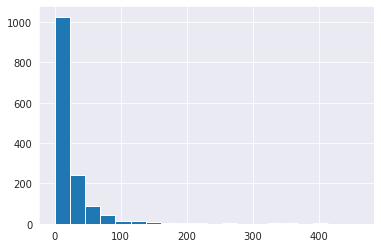

In [41]:
df_train['total_cases'].hist(bins=20)

In [42]:
df_train.iloc[:,4:12].describe()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k
count,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000
mean,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356
std,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810
min,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857
25%,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929
50%,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714
75%,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000
max,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000


In [43]:
df_train.iloc[:,12:18].describe()

,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg
count,1446.000000,1446.000000,1446.000000,1446.000000,1443.000000,1446.000000
mean,303.427109,295.719156,40.151819,82.161959,45.760388,16.746427
std,3.234601,2.565364,43.434399,7.153897,43.715537,1.542494
min,297.800000,286.900000,0.000000,57.787143,0.000000,11.715714
25%,301.000000,293.900000,13.055000,77.177143,9.800000,15.557143
50%,302.400000,296.200000,27.245000,80.301429,38.340000,17.087143
75%,305.500000,297.900000,52.200000,86.357857,70.235000,17.978214
max,314.000000,299.900000,570.500000,98.610000,390.600000,20.461429


In [44]:
df_train.iloc[:,18:24].describe()

,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


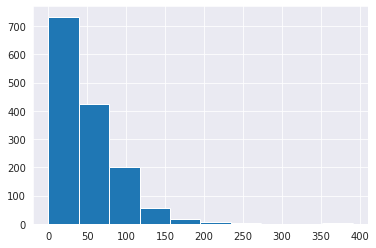

In [45]:
df_train.precipitation_amt_mm.hist()

In [46]:
df_train.isnull().sum()

week_start_date                            0
city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [47]:
train_labels.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [48]:
# split the training lables
sj_cases = train_labels[train_labels['city'] == 'sj']
iq_cases = train_labels[train_labels['city'] == 'iq']


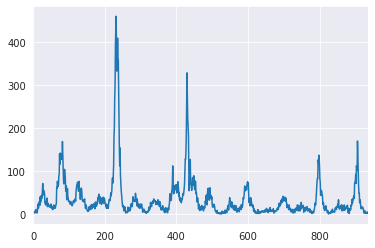

In [49]:
# chart the history of cases in San Juan
sj_cases['total_cases'].plot()


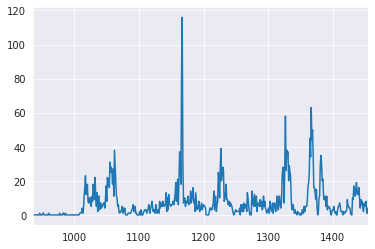

In [50]:
# chart the history of cases in Iquitos
iq_cases['total_cases'].plot()

In [51]:
# check for missing values in San Juan dataset
df_sj.isnull().sum()

week_start_date                            0
city                                       0
year                                       0
weekofyear                                 0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_mi

In [52]:
# look at the datatypes in the San Juan dataset
df_sj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 24 columns):
week_start_date                          936 non-null datetime64[ns]
city                                     936 non-null object
year                                     936 non-null int64
weekofyear                               936 non-null int64
ndvi_ne                                  745 non-null float64
ndvi_nw                                  887 non-null float64
ndvi_se                                  917 non-null float64
ndvi_sw                                  917 non-null float64
precipitation_amt_mm                     927 non-null float64
reanalysis_air_temp_k                    930 non-null float64
reanalysis_avg_temp_k                    930 non-null float64
reanalysis_dew_point_temp_k              930 non-null float64
reanalysis_max_air_temp_k                930 non-null float64
reanalysis_min_air_temp_k                930 non-null float64
reanalysis_precip_amt_kg_

In [53]:
# check for missing values in the Iquitos dataset
df_iq.isnull().sum()

week_start_date                           0
city                                      0
year                                      0
weekofyear                                0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c              

In [54]:
# look at the datatypes in the Iquitos dataset
df_iq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 936 to 1455
Data columns (total 24 columns):
week_start_date                          520 non-null datetime64[ns]
city                                     520 non-null object
year                                     520 non-null int64
weekofyear                               520 non-null int64
ndvi_ne                                  517 non-null float64
ndvi_nw                                  517 non-null float64
ndvi_se                                  517 non-null float64
ndvi_sw                                  517 non-null float64
precipitation_amt_mm                     516 non-null float64
reanalysis_air_temp_k                    516 non-null float64
reanalysis_avg_temp_k                    516 non-null float64
reanalysis_dew_point_temp_k              516 non-null float64
reanalysis_max_air_temp_k                516 non-null float64
reanalysis_min_air_temp_k                516 non-null float64
reanalysis_precip_amt_

In [55]:
# the Iquiotos dataset needed the index reset
df_iq = df_iq.reset_index(drop=True)

In [56]:
df_iq.head()


,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,2000-07-01,iq,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0
1,2000-07-08,iq,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6
2,2000-07-15,iq,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1
3,2000-07-22,iq,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0
4,2000-07-29,iq,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0


In [57]:
# drop the no longer needed city factor from each dataset
df_sj.drop('city', axis=1, inplace=True)
df_iq.drop('city', axis=1, inplace=True)

In [58]:
# the only factor missing more than 10% of values is 'ndvi_ne' in the San Juan dataset.
# look at summary stats for this factor
df_sj['ndvi_ne'].describe()

count    745.000000
mean       0.057925
std        0.107153
min       -0.406250
25%        0.004500
50%        0.057700
75%        0.111100
max        0.493400
Name: ndvi_ne, dtype: float64

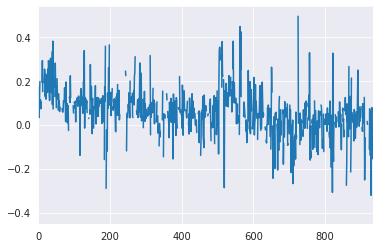

In [59]:
df_sj['ndvi_ne'].plot()

In [60]:
# a substantial "chunk" of data is missing in weeks around 250. In that range it looks like filling
# with the mean of 0.05 will be a reasonable choice. I will fill this and all the other missing values
# with the mean of each factor.

In [61]:
# function to fill values with the mean of a factor, skipping the date_time column
def fill_mean(dataframe):
    for i, col in enumerate(dataframe):
#         print(col)
        if col != 'week_start_date':
            dataframe[col].fillna(dataframe[col].mean(), inplace=True)

In [62]:
fill_mean(df_sj)

In [63]:
fill_mean(df_iq)

In [64]:
# check for nulls again
df_sj.isnull().sum()

week_start_date                          0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

In [65]:
# check for nulls again
df_iq.isnull().sum()

week_start_date                          0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
precipitation_amt_mm                     0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
dtype: int6

# Summary of the DrivenData records

Training datasets:
* df_sj = 936 records
* df_iq = 520 records


Labels datasets:
* sj_train_labels - 936 records
* iq_train_labels - 520 records

Labels dataframes have these columns: 'year', 'weekofyear', 'total_cases'

The training and label datasets for each city are in matching week order.

In [66]:
df_sj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 23 columns):
week_start_date                          936 non-null datetime64[ns]
year                                     936 non-null int64
weekofyear                               936 non-null int64
ndvi_ne                                  936 non-null float64
ndvi_nw                                  936 non-null float64
ndvi_se                                  936 non-null float64
ndvi_sw                                  936 non-null float64
precipitation_amt_mm                     936 non-null float64
reanalysis_air_temp_k                    936 non-null float64
reanalysis_avg_temp_k                    936 non-null float64
reanalysis_dew_point_temp_k              936 non-null float64
reanalysis_max_air_temp_k                936 non-null float64
reanalysis_min_air_temp_k                936 non-null float64
reanalysis_precip_amt_kg_per_m2          936 non-null float64
reanalysis_relative_humi

In [67]:
sj_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 3 columns):
year           936 non-null int64
weekofyear     936 non-null int64
total_cases    936 non-null int64
dtypes: int64(3)
memory usage: 29.2 KB


In [68]:
df_iq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 23 columns):
week_start_date                          520 non-null datetime64[ns]
year                                     520 non-null int64
weekofyear                               520 non-null int64
ndvi_ne                                  520 non-null float64
ndvi_nw                                  520 non-null float64
ndvi_se                                  520 non-null float64
ndvi_sw                                  520 non-null float64
precipitation_amt_mm                     520 non-null float64
reanalysis_air_temp_k                    520 non-null float64
reanalysis_avg_temp_k                    520 non-null float64
reanalysis_dew_point_temp_k              520 non-null float64
reanalysis_max_air_temp_k                520 non-null float64
reanalysis_min_air_temp_k                520 non-null float64
reanalysis_precip_amt_kg_per_m2          520 non-null float64
reanalysis_relative_humi

In [69]:
iq_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 936 to 1455
Data columns (total 3 columns):
year           520 non-null int64
weekofyear     520 non-null int64
total_cases    520 non-null int64
dtypes: int64(3)
memory usage: 16.2 KB


# Finalization of the DrivenData datasets 

In [70]:
# add the total_cases value to the training datasets
sj_final = df_sj.copy()
sj_final['total_cases'] = sj_train_labels['total_cases']

In [71]:
sj_final.head()

,week_start_date,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990-04-30,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990-05-07,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990-05-14,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990-05-21,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990-05-28,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [72]:
# reset the index of the Iquitos training labels dataset
iq_train_labels = iq_train_labels.reset_index(drop=True)

In [73]:
# add the total_cases value to the training datasets
iq_final = df_iq.copy()
iq_final['total_cases'] = iq_train_labels['total_cases']

In [74]:
iq_final.head()

,week_start_date,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,2000-07-01,2000,26,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,...,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
1,2000-07-08,2000,27,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,...,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
2,2000-07-15,2000,28,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,...,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
3,2000-07-22,2000,29,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,...,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
4,2000-07-29,2000,30,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,...,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


In [75]:
# drop the unnecessary columns in the final datasets
sj_final.drop(['year', 'weekofyear'], axis=1, inplace=True)
iq_final.drop(['year', 'weekofyear'], axis=1, inplace=True)

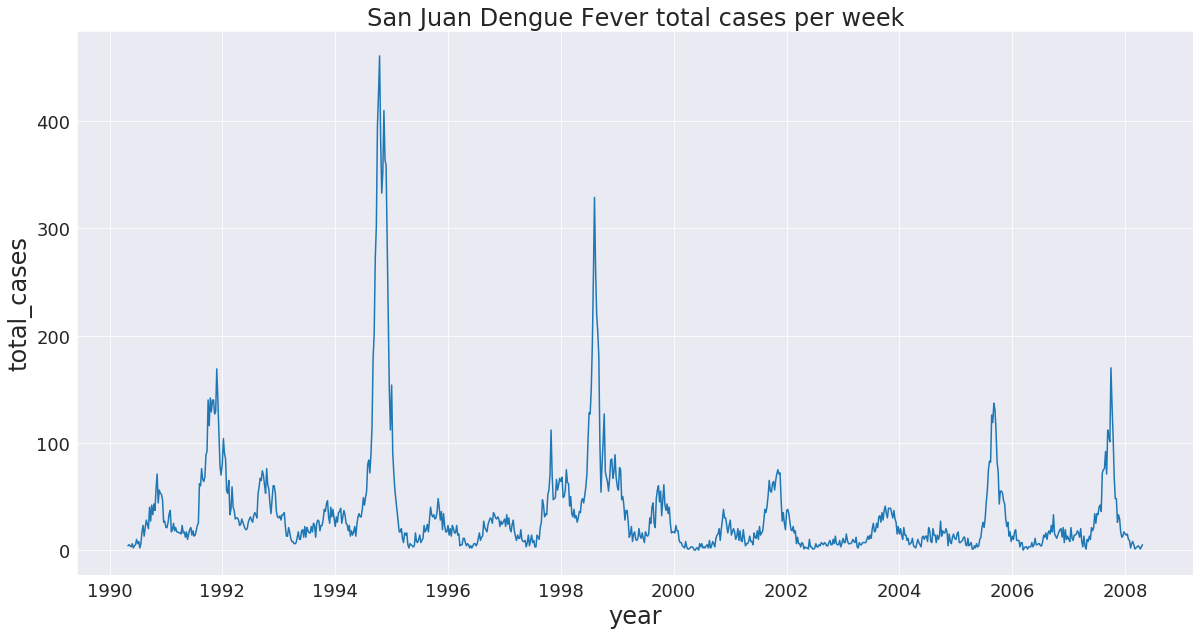

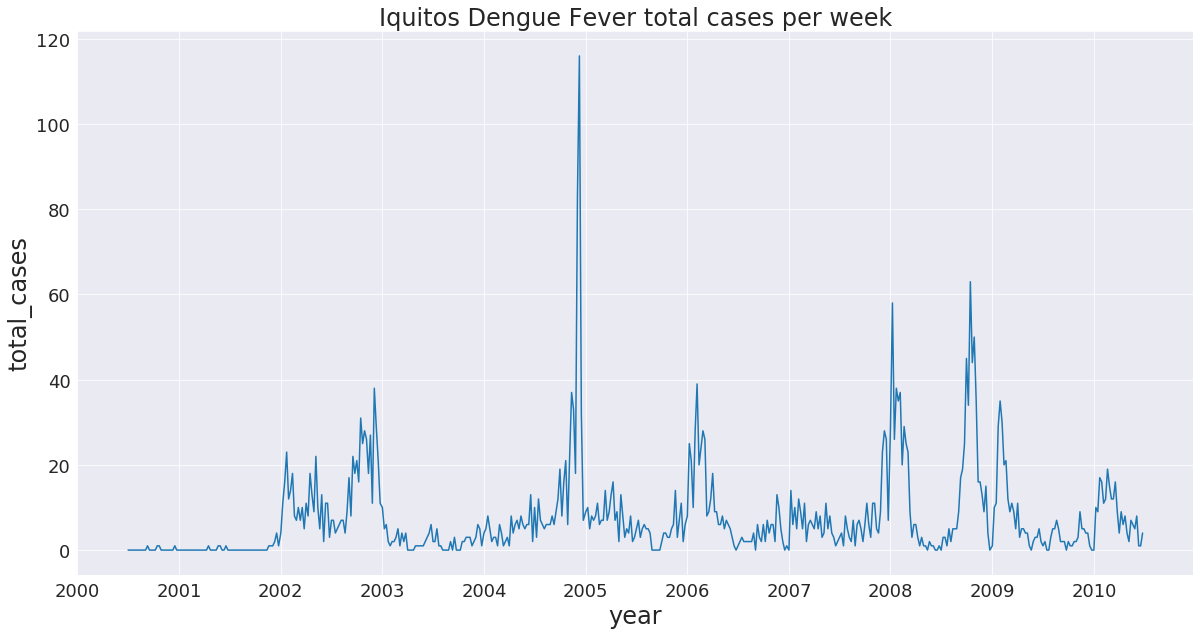

In [79]:
# look at the history of cases in San Juan by year
print('\n')
x = sj_final['week_start_date']
y = sj_final['total_cases']
plt.figure(figsize=(20,10))
plt.plot(x,y)
plt.xlabel('year', fontsize=24)
plt.ylabel('total_cases', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('San Juan Dengue Fever total cases per week', fontsize=24)
plt.show()

print('\n')

# look at the history of cases in Iquitos by year
x = iq_final['week_start_date']
y = iq_final['total_cases']
plt.figure(figsize=(20,10))
plt.plot(x,y)
plt.xlabel('year', fontsize=24)
plt.ylabel('total_cases', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Iquitos Dengue Fever total cases per week', fontsize=24)
plt.show()


## Some observations about the total_cases history:
### In San Juan, the total cases seem to rise in second half of the year, with particularly large spikes in cases in 1995 and 1999.
### In Iquitos the total cases also seem to rise in the second half of the year, with a very large spike in 2004, with another two large spikes in 2007 and 2008. The spikes in Iquitos seem to occur a few months later than in San Juan.

In [80]:
# look at how a chosen test proportion for each dataset will fall on the history of total_cases

proportions = [.6, .65, .70, .75, .8, .85, .9, .95]

def show_dates(df):
    for proportion in proportions:
        start_index = math.floor(len(df) * proportion)
        proportion_text = str(proportion*100)
        date = df.iloc[start_index][0]
        
#         sub_df.iloc[0]['A']

#         week = row.iloc[0]
        print('Start week at {} percent for training is {}'.format(proportion_text, date))


In [81]:
show_dates(sj_final)

Start week at 60.0 percent for training is 2001-02-12 00:00:00
Start week at 65.0 percent for training is 2002-01-08 00:00:00
Start week at 70.0 percent for training is 2002-12-03 00:00:00
Start week at 75.0 percent for training is 2003-10-29 00:00:00
Start week at 80.0 percent for training is 2004-09-16 00:00:00
Start week at 85.0 percent for training is 2005-08-13 00:00:00
Start week at 90.0 percent for training is 2006-07-09 00:00:00
Start week at 95.0 percent for training is 2007-06-04 00:00:00


In [82]:
show_dates(iq_final)

Start week at 60.0 percent for training is 2006-07-02 00:00:00
Start week at 65.0 percent for training is 2007-01-01 00:00:00
Start week at 70.0 percent for training is 2007-07-02 00:00:00
Start week at 75.0 percent for training is 2008-01-01 00:00:00
Start week at 80.0 percent for training is 2008-07-01 00:00:00
Start week at 85.0 percent for training is 2009-01-01 00:00:00
Start week at 90.0 percent for training is 2009-07-02 00:00:00
Start week at 95.0 percent for training is 2010-01-01 00:00:00


For San Juan, choosing a date prior to 2006 will force the model to predict cases in years 2006 to 2007. This corresponds to a training proportion of about .87

For Iquitos, choosing a date prior to mid-2008 will force the model to test predict cases in the last half of 2008, all of 2009, and the first half of 2010. This corresponds to a training proportion of about .79

# Functions to prepare the data and the LSTM models

In [83]:
# function converts a time series for supervised learning
# modified from 
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    arguments:
    data: list of values
    n_in: lookback time period(s)
    n_out: prediction time period(s)
    dropnan: True/False
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [84]:
# create function to create models and display results

def run_lstm(dataset_in, dataset_name_string, chart_title, start_col, end_col, 
             lookback_periods, train_proportion, dropout_proportion, epoch_count):
    '''
    dataset_in: pandas dataframe
    dataset_name_string: string for name of dataset_in, used in report
    chart_title: string for plot title
    start_col: index of column to start training data with
    end_col: index of column to end the training date from
    lookback_periods: prior time periods to use when predicting
    train_proportion: proportion of the dataset to use for the training data (0-1)
    dropout_proportion: proportion of nodes in the dropout layer to randomly disable during an epoch
    epoch_count: number of epochs to run the model
    '''
    
    #get values, starting with start_col, which in these datasets skips 'week_start_date'
    dataset = dataset_in.copy()
    values = dataset[dataset.columns[start_col:end_col]].values

    # ensure all data are of type float32
    values = values.astype('float32')

    # normalize all features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # convert data to proper format for supervised learning using lookback_periods
    reframed = series_to_supervised(scaled, lookback_periods, 1)

    # split the data into train and test sets based on given proportion
    values = reframed.values
    n_train_weeks = math.floor(len(values) * train_proportion)
    train = values[:n_train_weeks, :]
    test = values[n_train_weeks:, :]
    
    # split into explanatry (as opposed to independant) and response variables. 
    # Last column, 'total_cases' is the response variable
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # Create an LSTM model with a dropout layer of specified probability as the second layer,
    # and number of epochs specified
    model = Sequential()
    
    model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

    # dropout layer
    model.add(Dropout(dropout_proportion))

    model.add(Dense(50, activation='relu'))

    # output layer
    model.add(Dense(1))

    model.compile(loss='mae', optimizer='adam')

    # fit model
    history = model.fit(train_X, train_y, epochs=epoch_count, batch_size=72, 
                        validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    # output
    print('Dataset name: {}'.format(dataset_name_string))
    print('Lookback window periods: {}'.format(lookback_periods))
    print('Training proportion: {}'.format(train_proportion))
    print('Dropout proportion: {}'.format(dropout_proportion))
    print('last epoch loss: {}'.format(history.history['loss'][-1]))
    print('last epoch val_loss: {}'.format(history.history['val_loss'][-1]))

    # plot history
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss proportion', fontsize=20)
    plt.legend(fontsize=20)
    plt.title('Location: {}'.format(chart_title), fontsize=24)
    plt.show()
        

In [ ]:
# create function to create models and display mae

def run_lstm_preds(dataset_in, dataset_name_string, chart_title, start_col, end_col, 
             lookback_periods, train_proportion, dropout_proportion, epoch_count):
    '''
    dataset_in: pandas dataframe
    dataset_name_string: string for name of dataset_in, used in report
    chart_title: string for plot title
    start_col: index of column to start training data with
    end_col: index of column to end the training date from
    lookback_periods: prior time periods to use when predicting
    train_proportion: proportion of the dataset to use for the training data (0-1)
    dropout_proportion: proportion of nodes in the dropout layer to randomly disable during an epoch
    epoch_count: number of epochs to run the model
    '''
    
    #get values, starting with start_col, which in these datasets skips 'week_start_date'
    dataset = dataset_in.copy()
    values = dataset[dataset.columns[start_col:end_col]].values

    # ensure all data are of type float32
    values = values.astype('float32')

    # normalize all features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # convert data to proper format for supervised learning using lookback_periods
    reframed = series_to_supervised(scaled, lookback_periods, 1)

    # split the data into train and test sets based on given proportion
    values = reframed.values
    n_train_weeks = math.floor(len(values) * train_proportion)
    train = values[:n_train_weeks, :]
    test = values[n_train_weeks:, :]
    
    # split into explanatry (as opposed to independant) and response variables. 
    # Last column, 'total_cases' is the response variable
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # Create an LSTM model with a dropout layer of specified probability as the second layer,
    # and number of epochs specified
    model = Sequential()
    
    model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))

    # dropout layer
    model.add(Dropout(dropout_proportion))

    model.add(Dense(50, activation='relu'))

    # output layer
    model.add(Dense(1))

    model.compile(loss='mae', optimizer='adam')

    # fit model
    history = model.fit(train_X, train_y, epochs=epoch_count, batch_size=72,
                        validation_data=(test_X, test_y), verbose=0, shuffle=False)
    
    
    val_mae = model.evaluate(test_X, test_y, verbose=0)
    #     return val_mae
    
    preds = model.predict(test_X)
#     return preds
    
    
    # output
    print('Dataset name: {}'.format(dataset_name_string))
    print('Lookback window periods: {}'.format(lookback_periods))
    print('Training proportion: {}'.format(train_proportion))
    print('Dropout proportion: {}'.format(dropout_proportion))
    print('last epoch loss: {}'.format(history.history['loss'][-1]))
    print('last epoch val_loss: {}'.format(history.history['val_loss'][-1]))

#     # plot history
    plt.figure(figsize=(20,10))
    plt.plot(preds, label='predictions')
    plt.plot(test_y, label='actual value')
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('total_cases', fontsize=20)
    plt.legend(fontsize=20)
    plt.title('Location: {}'.format(chart_title), fontsize=24)
    plt.show()

# Run some trials using only the data from drivendata.org

## San Juan models

Dataset name: sj_final
Lookback window periods: 4
Training proportion: 0.87
Dropout proportion: 0.3
last epoch loss: 0.018984903684920736
last epoch val_loss: 0.015915911858443352


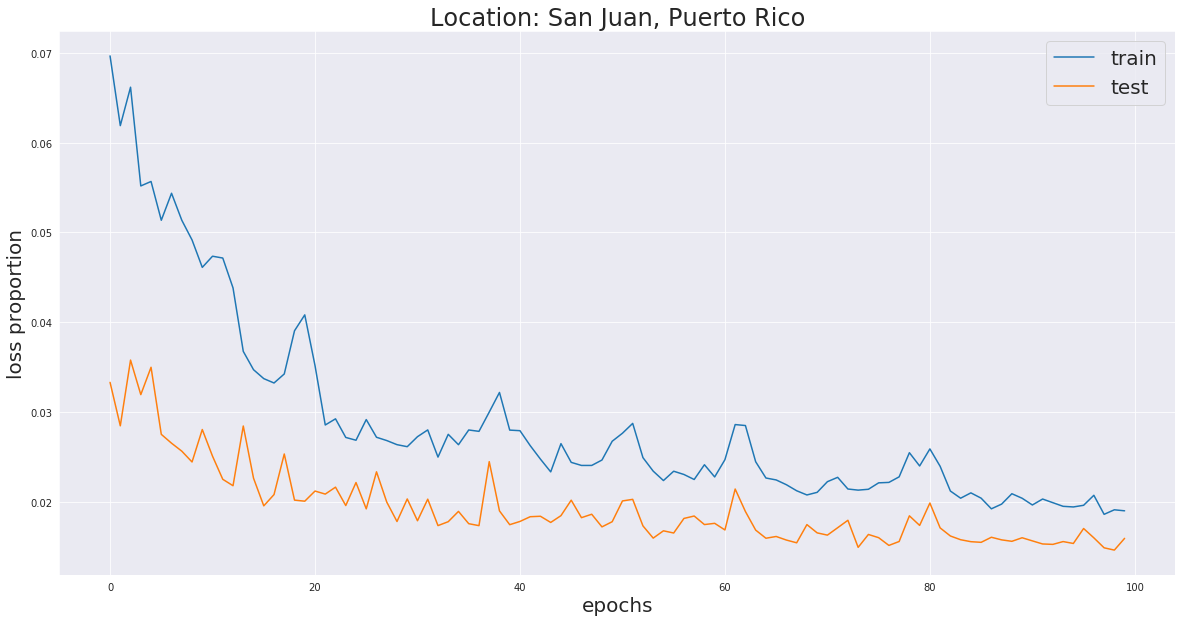

In [85]:
# for reference
# run_lstm(dataset_in, dataset_name_string, chart_title, start_col, end_col, 
#          lookback_periods, train_proportion, dropout_proportion, epoch_count)

# San Juan
run_lstm(sj_final, 'sj_final', 'San Juan, Puerto Rico', 1, 23, 4, .87, .3, 100)

Dataset name: sj_final
Lookback window periods: 4
Training proportion: 0.87
Dropout proportion: 0.4
last epoch loss: 0.02896896567609575
last epoch val_loss: 0.018028934348802098


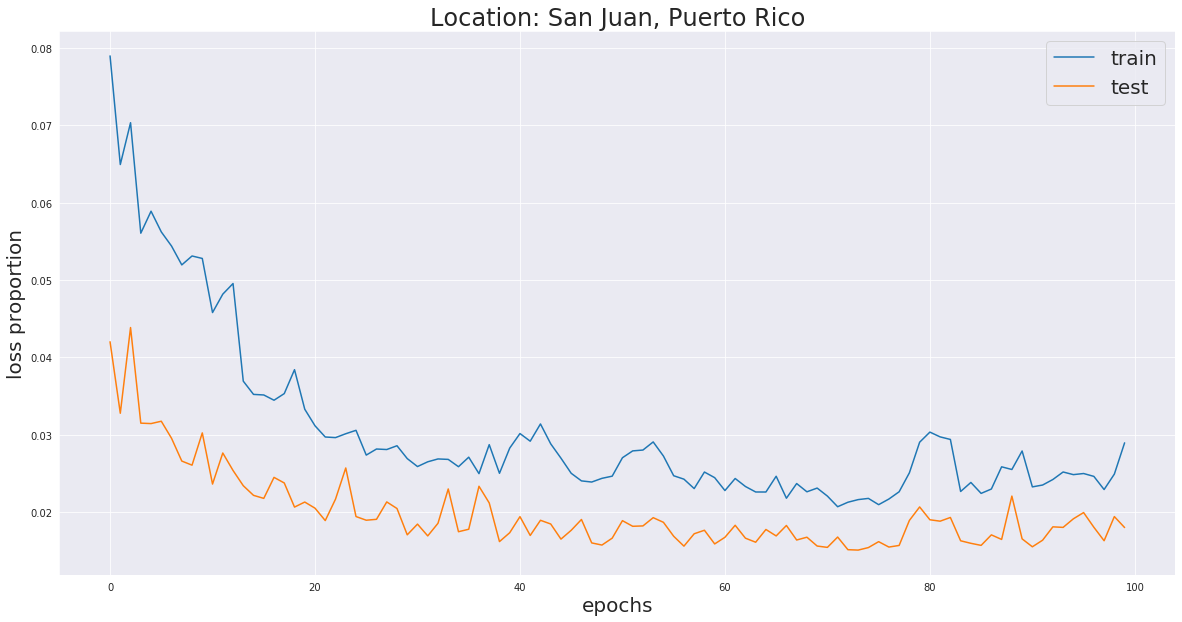

In [86]:
# try increasing the dropout probability
run_lstm(sj_final, 'sj_final', 'San Juan, Puerto Rico', 1, 23, 4, .87, .4, 100)

Dataset name: sj_final
Lookback window periods: 4
Training proportion: 0.87
Dropout proportion: 0.5
last epoch loss: 0.021776796297894585
last epoch val_loss: 0.016887114551223693


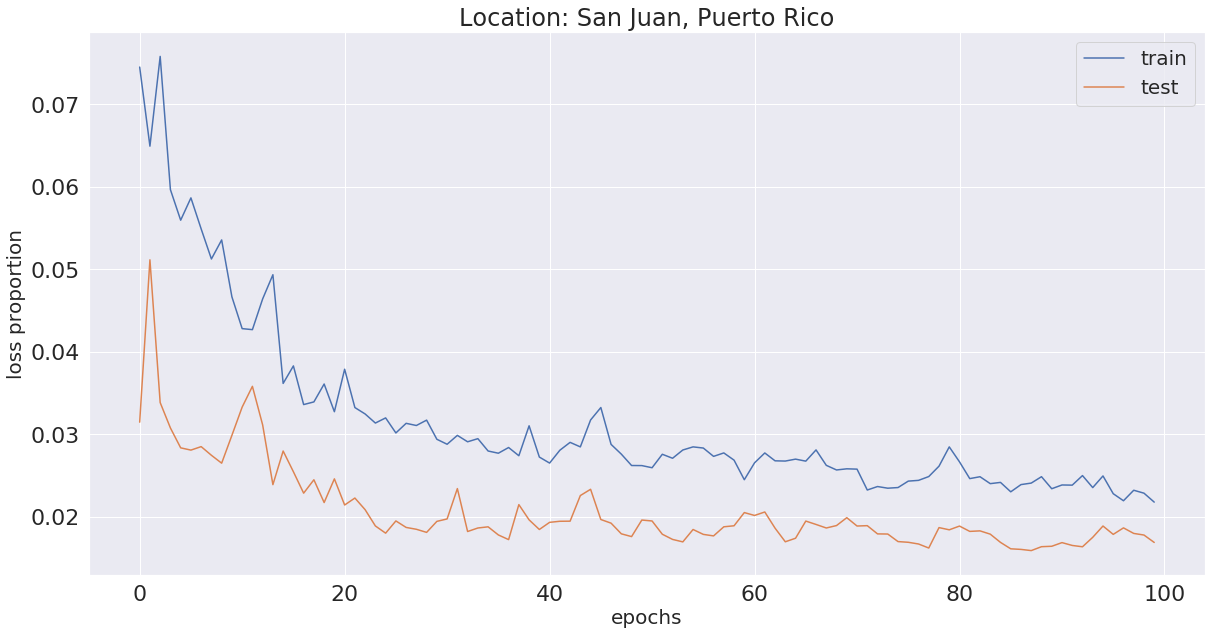

In [101]:
# try increasing the dropout probability again
run_lstm(sj_final, 'sj_final', 'San Juan, Puerto Rico', 1, 23, 4, .87, .5, 100)

The model directly above is the best performing model for San Juan.

In [ ]:
# look at the mae
run_lstm_preds(sj_final, 'sj_final', 'San Juan, Puerto Rico', 1, 23, 4, .87, .5, 100)

In [ ]:
temp

Dataset name: sj_final
Lookback window periods: 3
Training proportion: 0.87
Dropout proportion: 0.5
last epoch loss: 0.023952055816640835
last epoch val_loss: 0.016475202912678483


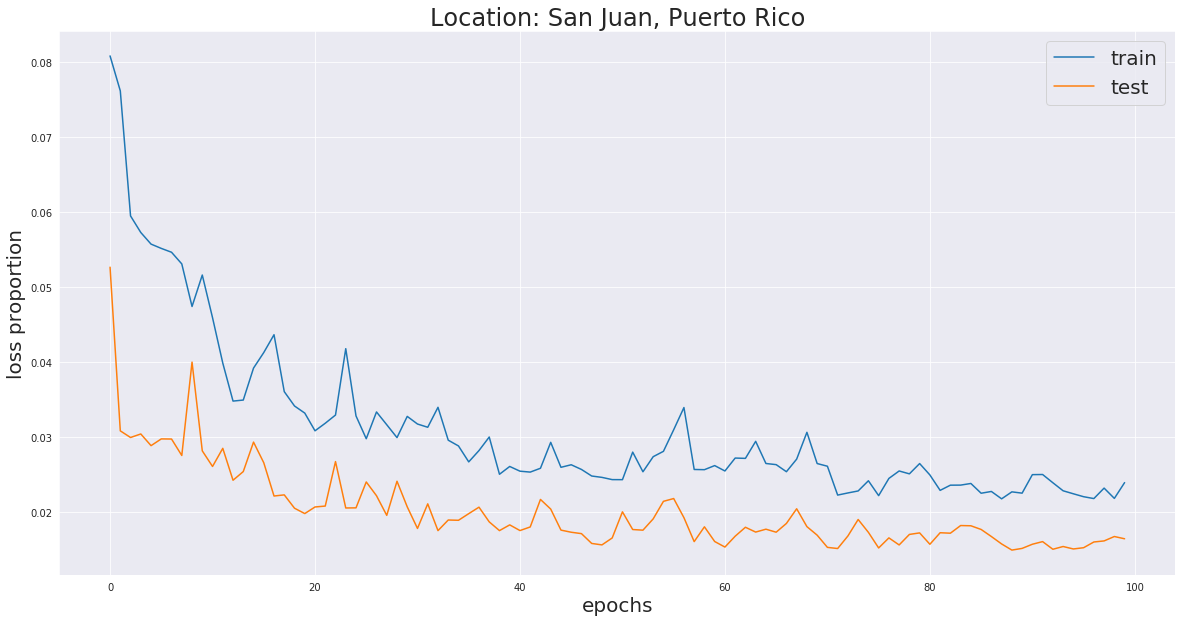

In [88]:
# try decreasing the lookback periods
run_lstm(sj_final, 'sj_final', 'San Juan, Puerto Rico', 1, 23, 3, .87, .5, 100)

Dataset name: sj_final
Lookback window periods: 2
Training proportion: 0.87
Dropout proportion: 0.5
last epoch loss: 0.022782118669871627
last epoch val_loss: 0.015535031185775507


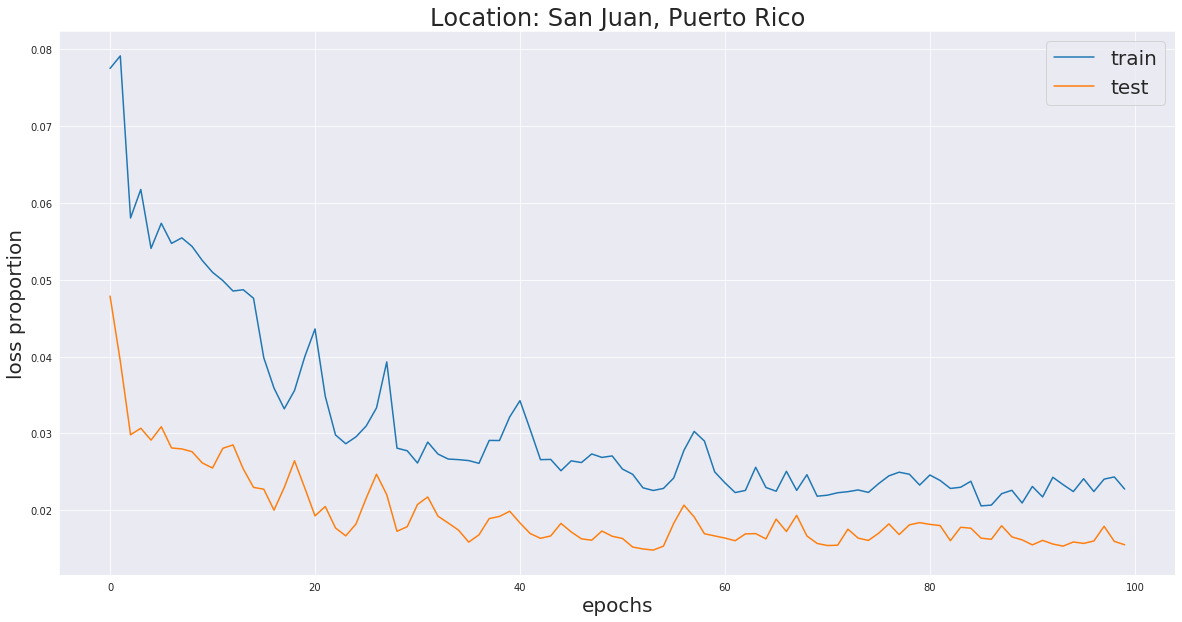

In [89]:
# try decreasing the lookback periods
run_lstm(sj_final, 'sj_final', 'San Juan, Puerto Rico', 1, 23, 2, .87, .5, 100)

## Iquitos models

Dataset name: iq_final
Lookback window periods: 4
Training proportion: 0.79
Dropout proportion: 0.3
last epoch loss: 0.028146881527777678
last epoch val_loss: 0.036258908074109926


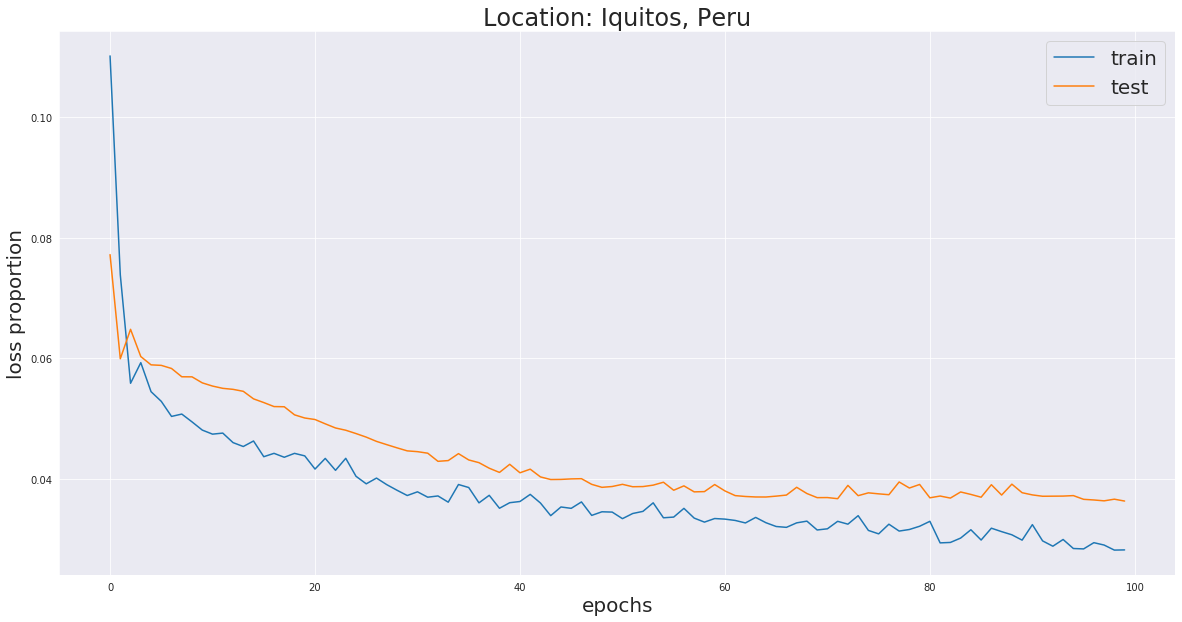

In [90]:
# for reference
# run_lstm(dataset_in, dataset_name_string, chart_title, start_col, end_col, 
#          lookback_periods, train_proportion, dropout_proportion, epoch_count)

# Iquitos
run_lstm(iq_final, "iq_final", "Iquitos, Peru", 1, 23, 4, .79, .3, 100)

Dataset name: iq_final
Lookback window periods: 4
Training proportion: 0.79
Dropout proportion: 0.4
last epoch loss: 0.02968940955268663
last epoch val_loss: 0.03589397593649155


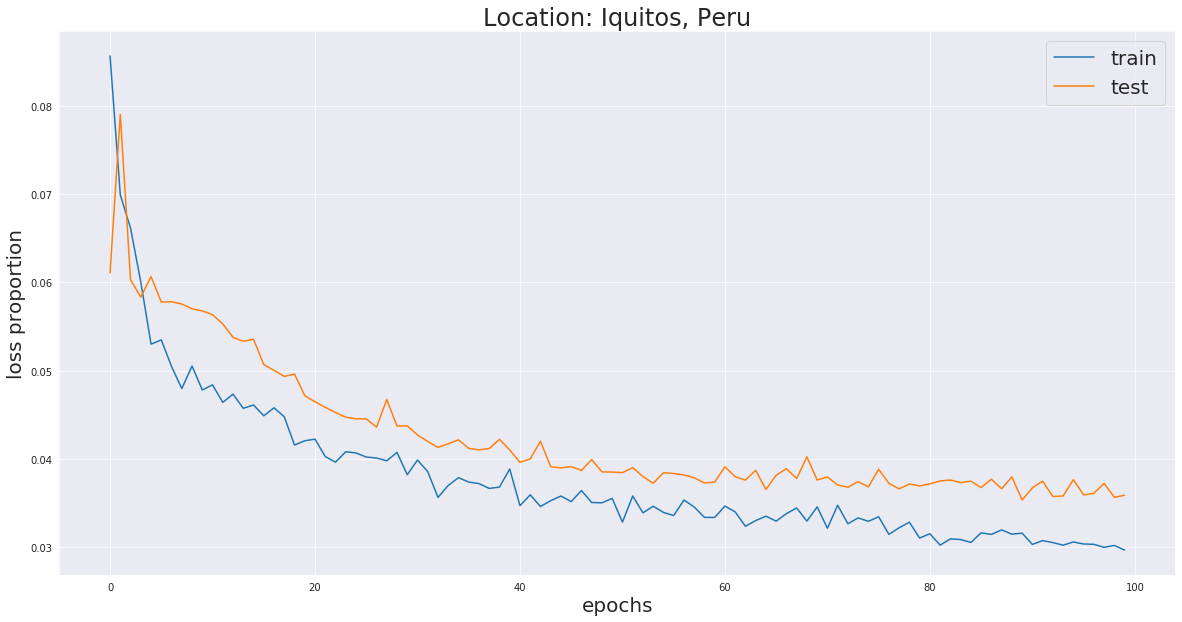

In [91]:
# increase dropout probability
run_lstm(iq_final, "iq_final", "Iquitos, Peru", 1, 23, 4, .79, .4, 100)

Dataset name: iq_final
Lookback window periods: 4
Training proportion: 0.79
Dropout proportion: 0.5
last epoch loss: 0.032202136155940975
last epoch val_loss: 0.037770198042923156


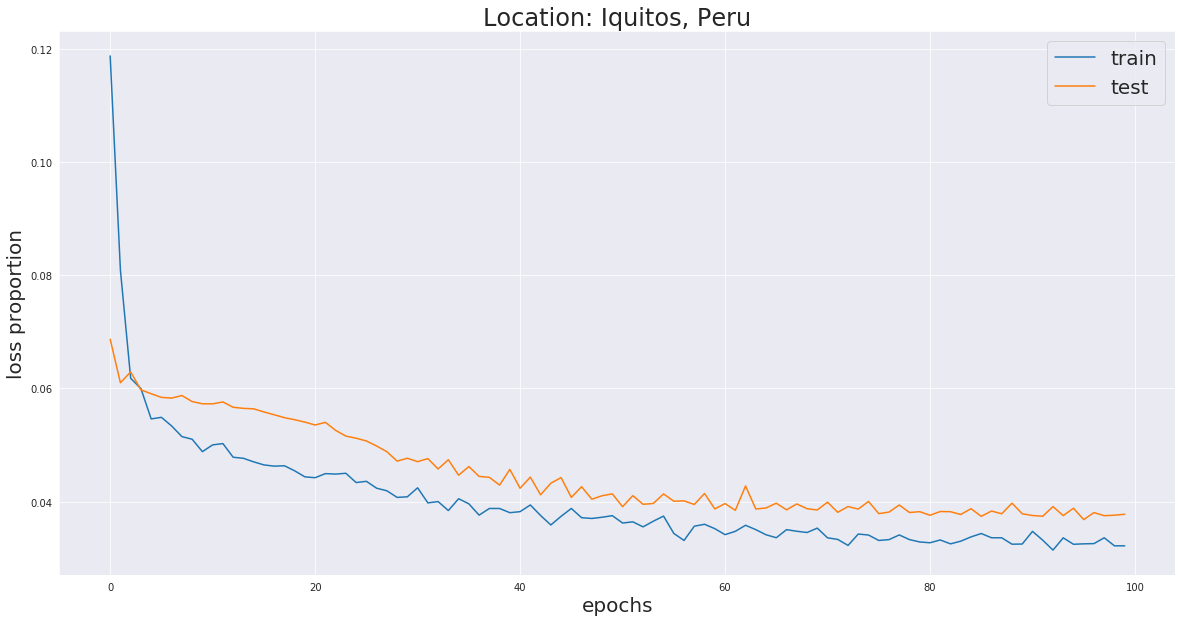

In [92]:
# increase dropout probability
run_lstm(iq_final, "iq_final", "Iquitos, Peru", 1, 23, 4, .79, .5, 100)

Dataset name: iq_final
Lookback window periods: 3
Training proportion: 0.79
Dropout proportion: 0.4
last epoch loss: 0.029152870726059463
last epoch val_loss: 0.037125394602707765


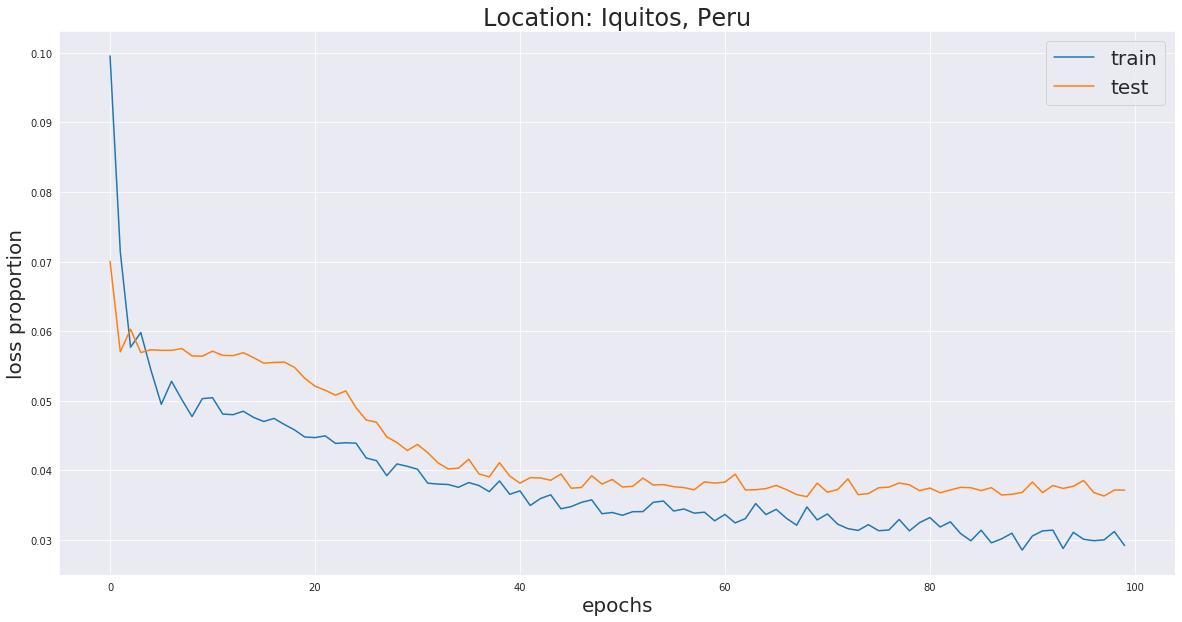

In [93]:
# decrease lookback periods
run_lstm(iq_final, "iq_final", "Iquitos, Peru", 1, 23, 3, .79, .4, 100)

Dataset name: iq_final
Lookback window periods: 2
Training proportion: 0.79
Dropout proportion: 0.4
last epoch loss: 0.03253880781656664
last epoch val_loss: 0.0359639747734737


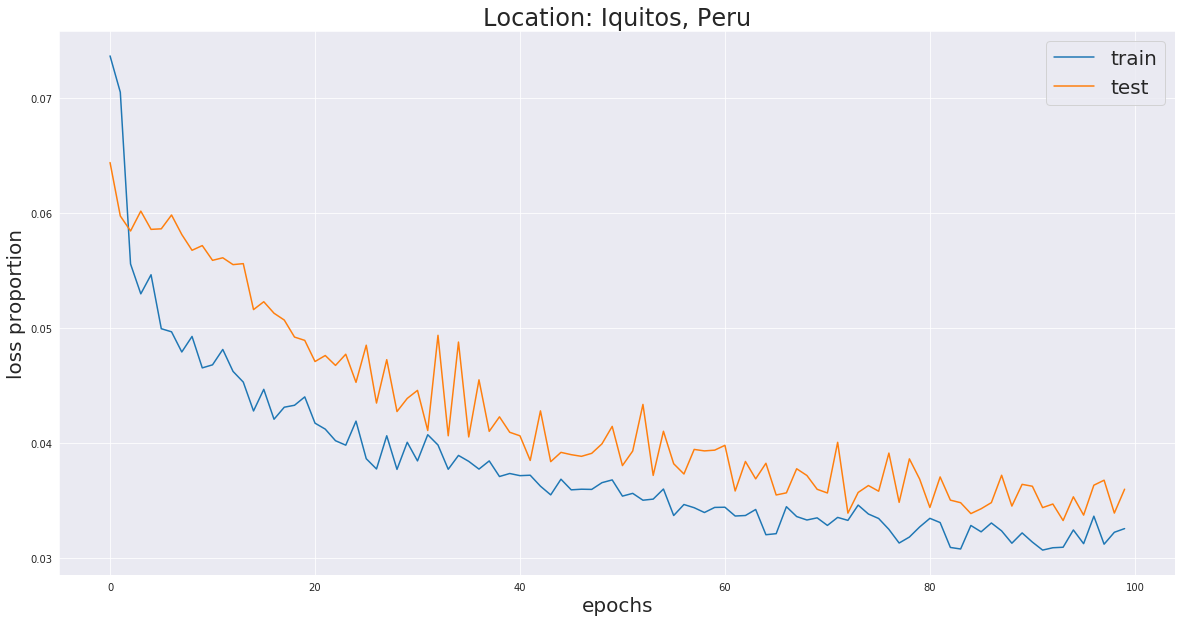

In [94]:
# decrease lookback periods
run_lstm(iq_final, "iq_final", "Iquitos, Peru", 1, 23, 2, .79, .4, 100)

Dataset name: iq_final
Lookback window periods: 1
Training proportion: 0.79
Dropout proportion: 0.4
last epoch loss: 0.03136305632751162
last epoch val_loss: 0.03180737925026942


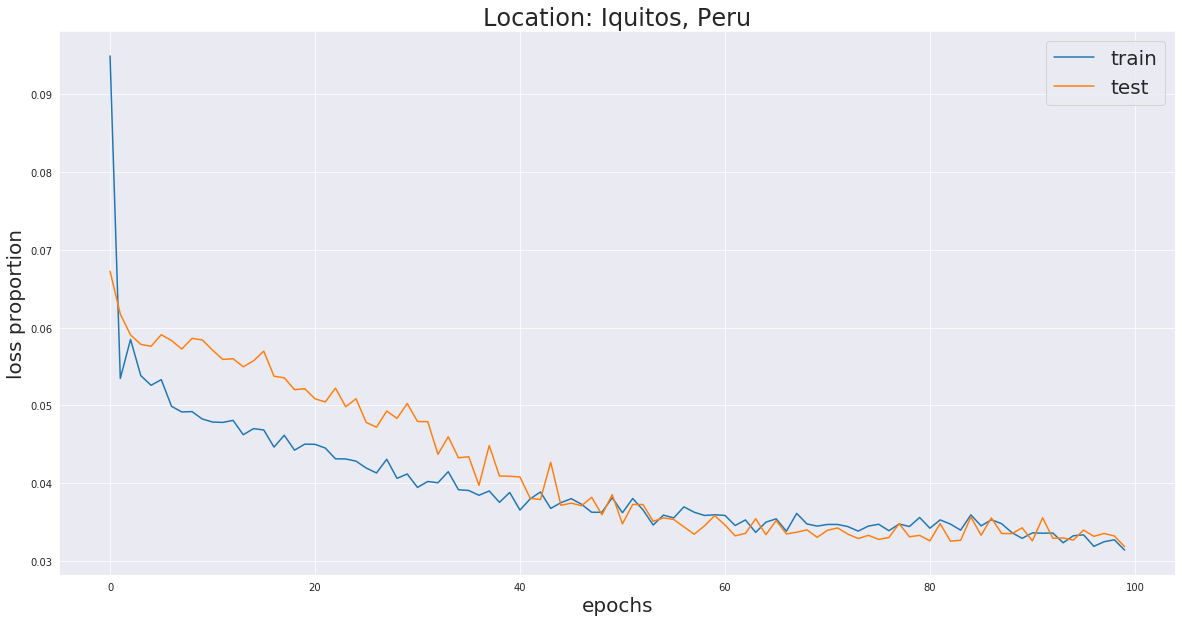

In [95]:
# decrease lookback periods
run_lstm(iq_final, "iq_final", "Iquitos, Peru", 1, 23, 1, .79, .4, 100)

The model above is the best performing model for Iquitos.

Dataset name: iq_final
Lookback window periods: 1
Training proportion: 0.85
Dropout proportion: 0.4
last epoch loss: 0.03947419619985989
last epoch val_loss: 0.02581095050733823


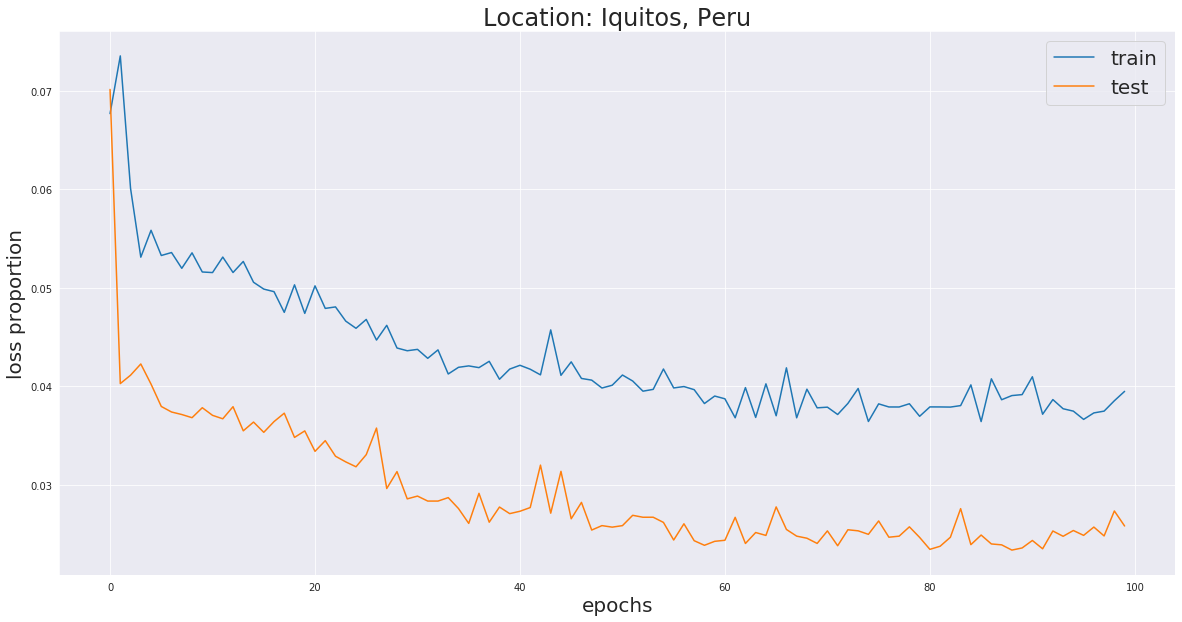

In [96]:
# try with 85% for the training data
run_lstm(iq_final, "iq_final", "Iquitos, Peru", 1, 23, 1, .85, .4, 100)

Dataset name: iq_final
Lookback window periods: 1
Training proportion: 0.9
Dropout proportion: 0.4
last epoch loss: 0.036821743094499926
last epoch val_loss: 0.018461089581251144


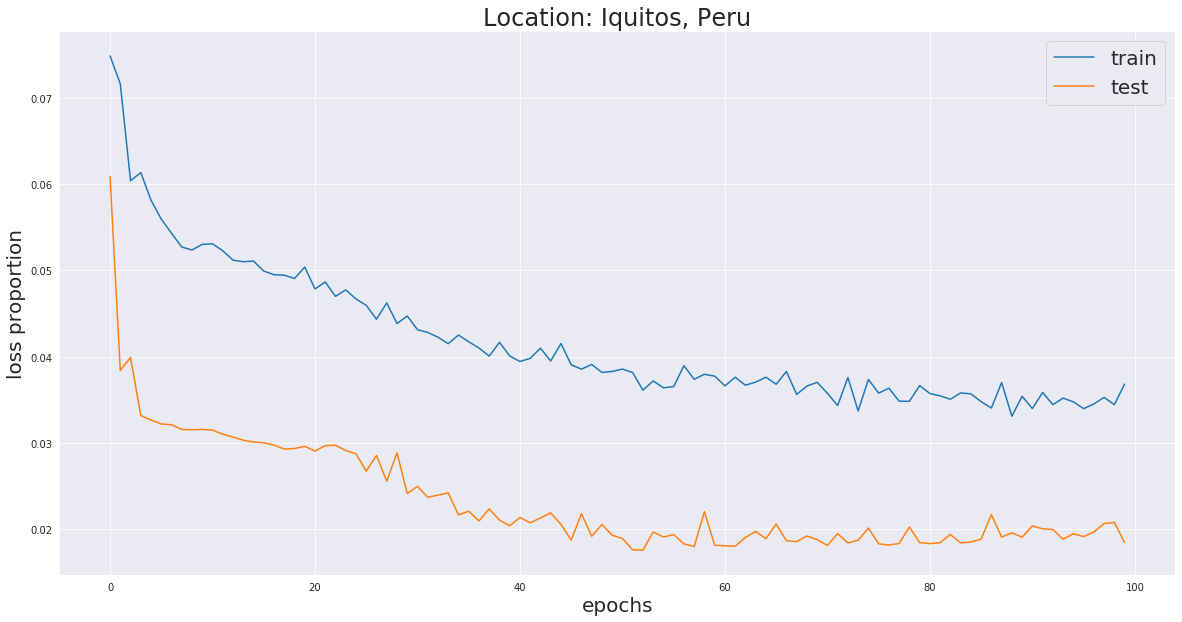

In [97]:
# try with 90% for the training data
run_lstm(iq_final, "iq_final", "Iquitos, Peru", 1, 23, 1, .9, .4, 100)

In [98]:
# look at how many weeks this last model is predicting
len(iq_final) * (1-.9)

51.999999999999986

For Iquitos, when using 90% of the data to train on, the model is only predicting the time period from roughly July 2009 to June 2010. During this time period there was not a large spike in dengue fever cases. The improved accuracy may be due to the model not having to predict such an event. The fact that the model is significantly better during testing than training is perhaps an indication of this.

# Look at possible correlated factors

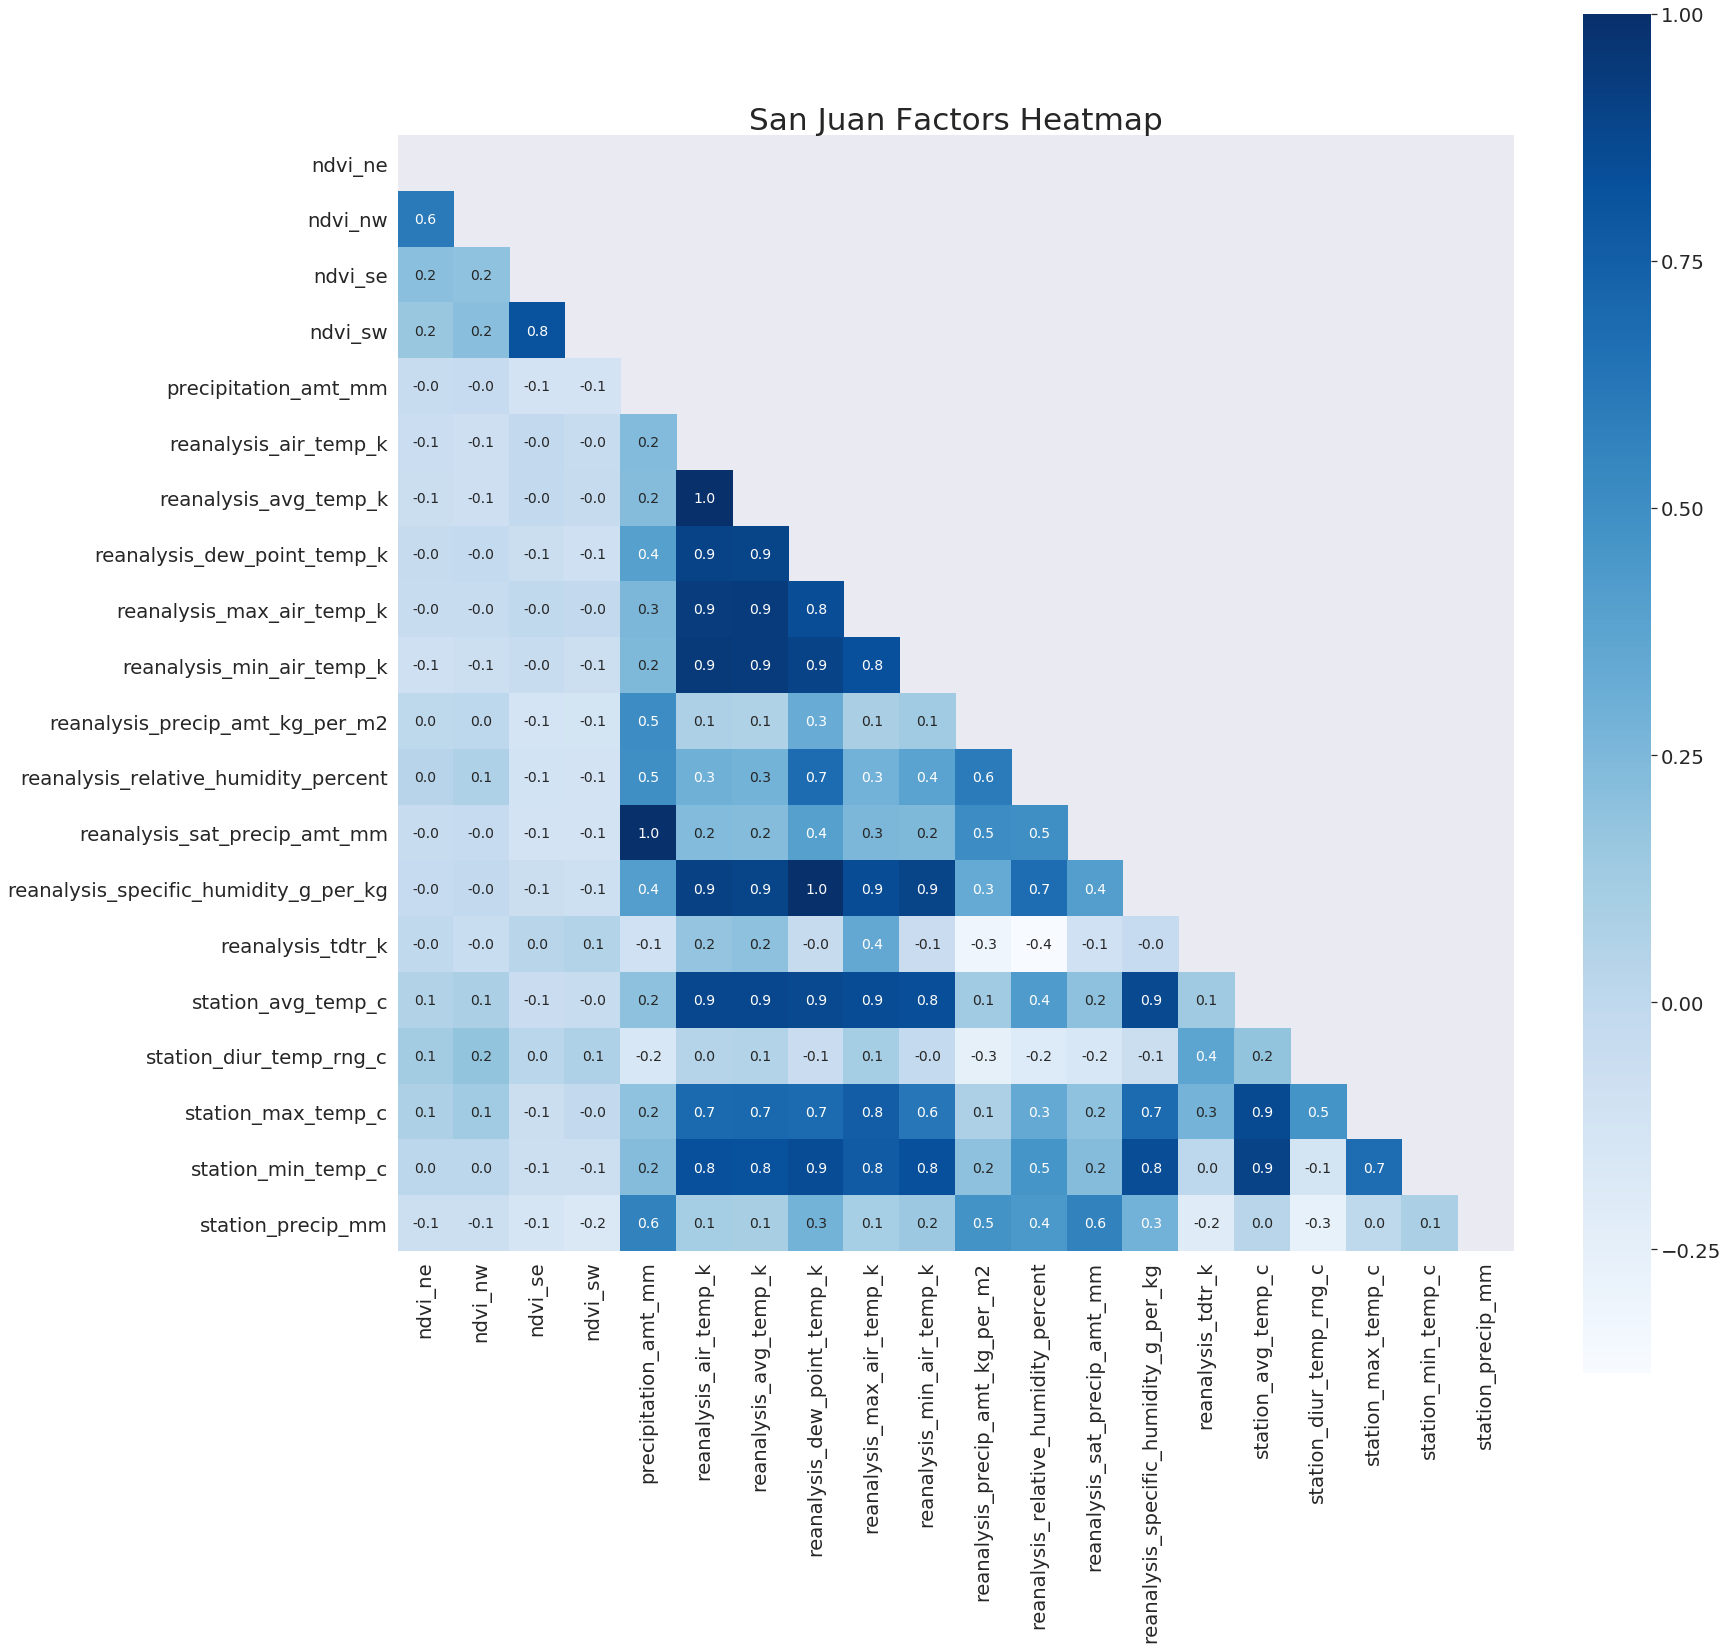

In [99]:
# look at a correlation heat map for San Juan
# some code modified from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white") #to make mask show notebook background

df_corr = sj_final.drop('total_cases', axis=1)
corr = df_corr.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.8)

f,ax = plt.subplots(figsize=(25,25))

hm = sns.heatmap(corr, mask=mask, annot=True, square=True, cmap="Blues", fmt='.1f', annot_kws={'size': 14} )

hm.set_ylim(20,0)
plt.title('San Juan Factors Heatmap', fontsize='x-large')
plt.show()

Weather data has a lot of factors that are strongly correlated with each other.

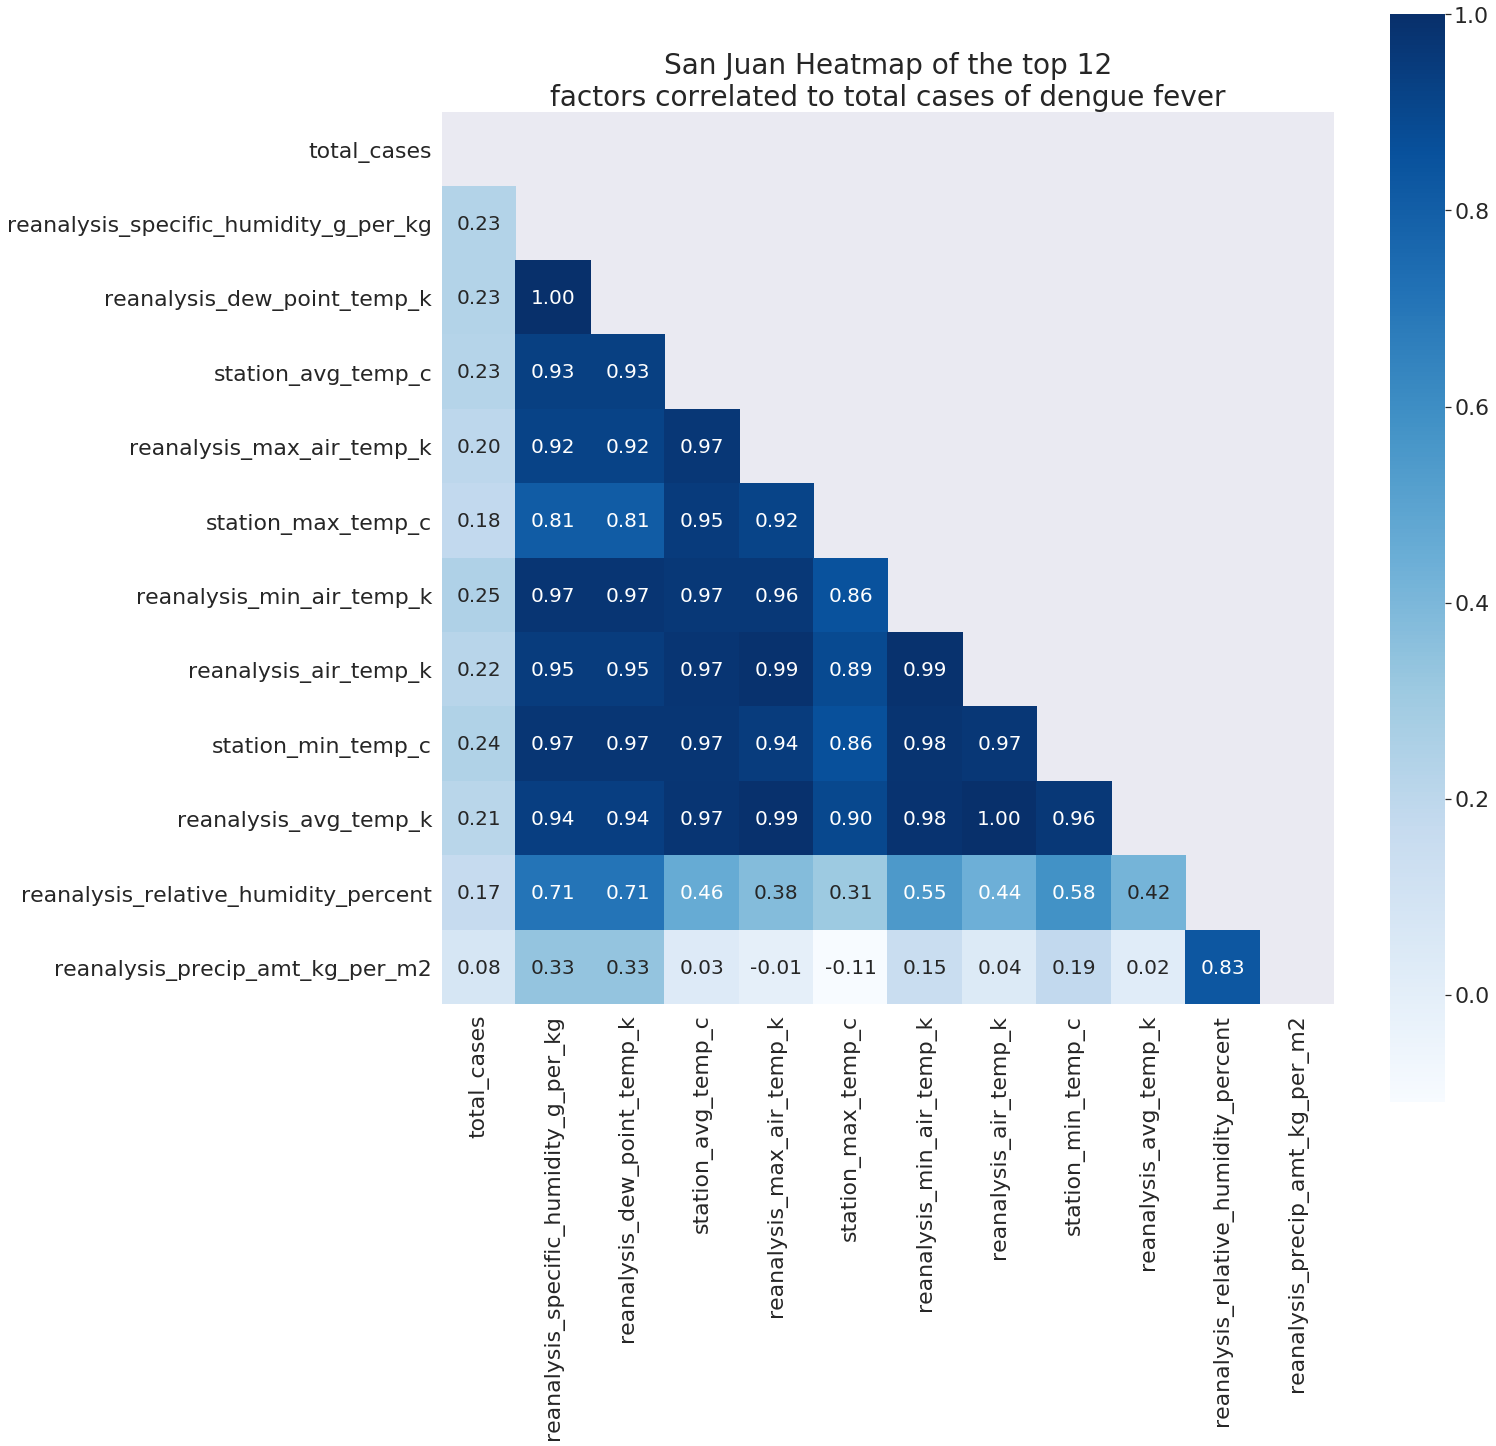

In [100]:
# look at the top 12 factors, as correlated to dengue fever cases, are correlated with each other

sns.set(style="white")

corr_to_target = sj_final.corr()

k = 12 #number of variables for heatmap

cols = corr_to_target.nlargest(k, 'total_cases')['total_cases'].index

cm = np.corrcoef(corr_to_target[cols].values.T)

mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=2)

fig = plt.figure(figsize=(20,20))

hm = sns.heatmap(cm, cbar=True, annot=True, mask=mask, square=True, cmap="Blues", fmt='.2f', annot_kws={'size': 20},
                 yticklabels = cols.values, xticklabels = cols.values)

hm.set_ylim(12,0)

plt.title('San Juan Heatmap of the top {}\nfactors correlated to total cases of dengue fever'.format(k), fontsize=28)
plt.show()

# Obtain additional weather data from DarkSky to see if the models can be improved

In [ ]:
# get darksky.net historical weather information

# request format:  https://api.darksky.net/forecast/[key]/[latitude],[longitude],[time]

# San Juan, Puerto Rico - Latitude: 18.4653, Longitude: -66.1167
# Iquitos, Peru:  - Latitude: -3.74937, Longitude: -73.2444

In [ ]:
# this gets current SF weather forecast
# SF: 37.7648, -122.463

# target = 'https://api.darksky.net/forecast/9501b92a37587155d222ae11b77c65a3/37.63474, -122.109015'

# req = requests.get(url=target)
# json_data = json.loads(req.text)
# print(json.dumps(json_data, indent=4, sort_keys=True))

Strategy for additional environmental data:

Collect the dark sky data into a seperate dataframe with daily values for each city

San Juan first week start date is 1990-04-30 (Monday)
San Juan last week start date is 2008-04-22 (Tuesday)

Iquitos first week start date is 2000-07-01 (Saturday)
Iquitos last week start date is 2010-06-25 (Friday)

The San Juan data is weekly and begins on Monday 1990-04-30 @ 12:00 AM and ends on Sunday 2008-04-28 @ 11:59 PM 
*** there appears to be a discrepancy in the weekly start day from the beginning to the end

The Iquitos data is weekly and begins on Saturday 2000-07-01 @ 12:00 AM and ends on Friday 2010-07-02 @ 11:59 PM
*** there appears to be a discrepancy in the weekly start day from the beginning to the end

Mosquito eggs can stay viable for over a decade, hatching when conditions are acceptable.

I am choosing to gather additional weather data for 1 year prior to the start dates above, so the dates I want weather data for are:

San Juan: 1989-05-01 to 2008-04-28

Iquitos:  1999-06-30 to 2010-07-02

In [268]:
# psuedo code for getting the darksky data at 1K/day

# each record in the training set has the city code and the start day of that week
# convert the start day of week to UNIX epoch timestamp at the city of the record, 
# ie. 2009-04-30 becomes 641433600 (midnight on 4/30/2009)


# make 7 calls to the api, incrementing each by 
# 
# set start year and day for sj and iq
# set end year and day for sj and iq
# make weather_data_df with two columns: index(auto), city, datetime
# for index in weather_data_df:
#   create the url
#   call the api
#   write the data to a df
#   save the df as a csv
# 

In [270]:
# get darksky.net historical weather information
# request format:  https://api.darksky.net/forecast/[key]/[latitude],[longitude],[time]

# variables
# San Juan, Puerto Rico - Latitude: 18.4653, Longitude: -66.1167
# Iquitos, Peru:  - Latitude: -3.74937, Longitude: -73.2444


darksky_key = '' # removed for security

sj_lat = 18.4653
sj_lon = -66.1167
iq_lat = -3.74937
iq_lon = -73.2444

sj_start = '1989-05-01'
sj_end = '2008-04-28'
iq_start = '1999-06-30'
iq_end = '2010-07-02'

sj_elapsed = pd.Timestamp(sj_end)  - pd.Timestamp(sj_start)
iq_elapsed = pd.Timestamp(iq_end) - pd.Timestamp(iq_start)

sj_day_count = sj_elapsed.days
iq_day_count = iq_elapsed.days

In [271]:
print(sj_day_count)
print(iq_day_count)

6937
4020


In [273]:
sj_day_list = pd.date_range(sj_start, periods=sj_day_count, freq='D')
iq_day_list = pd.date_range(iq_start, periods=iq_day_count, freq='D')

sj_days_df = pd.DataFrame(sj_day_list.astype(str))
iq_days_df = pd.DataFrame(iq_day_list.astype(str))

sj_days_df.columns = (['date'])
iq_days_df.columns = (['date'])

In [274]:
sj_days_df.head()

,date
0,1989-05-01
1,1989-05-02
2,1989-05-03
3,1989-05-04
4,1989-05-05


In [275]:
# original function to obtain darksky data
# throws an error about halfway through the 6K records for San Juan, stating that there was 
# a key error ['daily']


def get_darksky_data(key, latitude, longitude, days_df, start_index, count):

    start = datetime.datetime.now()
    print('Now obtaining {} days of records from DarkSky'.format(count))

    temp_df = pd.DataFrame()
    current_index = start_index
    for i in range(count):
        day = days_df.iloc[current_index]['date']
        day_string = day + 'T00:00:00'

        target = 'https://api.darksky.net/forecast/' + darksky_key + '/' + str(latitude) + ',' + str(longitude) + ',' + day_string + '?exclude=currently,hourly,flags'

        req = requests.get(url=target)
        json_data = json.loads(req.text)

        with open('temp_text.txt', 'a') as the_file:
            the_file.write(json.dumps(json_data, sort_keys=False) + '\n')
    
        current_index += 1

        temp_df = temp_df.append(json_normalize(json_data['daily']['data'], max_level=0), ignore_index=True, verify_integrity=True, sort=False)
    
    end = datetime.datetime.now()
    elapsed = end - start
    print('Obtaining {} days took a total of {}'.format(count, elapsed))

    return temp_df

In [276]:
def darksky_data_to_text_file(key, latitude, longitude, days_df, start_index, count, text_file):
    update_flag = True

    start = datetime.datetime.now()
    print('Now obtaining {} days of records from DarkSky and saving to {}'.format(count, text_file))

#     temp_df = pd.DataFrame()
    current_index = start_index
    for i in range(count):
        day = days_df.iloc[current_index]['date']
        day_string = day + 'T00:00:00'
#         print(day_string)
        target = 'https://api.darksky.net/forecast/' + darksky_key + '/' + str(latitude) + ',' + str(longitude) + ',' + day_string + '?exclude=currently,hourly,flags'
#         print(target)
        req = requests.get(url=target)
        json_data = json.loads(req.text)
#         print(json.dumps(json_data, indent=4, sort_keys=False))

        with open(text_file, 'a') as the_file:
            the_file.write(json.dumps(json_data, sort_keys=False) + '\n')
    
        current_index += 1
#         print(json_normalize(json_data['daily']['data'], max_level=0))
        
#         if json_data['daily']:
#         temp_df = temp_df.append(json_normalize(json_data['daily']['data'], max_level=0), ignore_index=True, verify_integrity=True, sort=False)
        if update_flag:
            if i == count // 10:
                end = datetime.datetime.now()
                elapsed = end - start
                remaining = elapsed * 9
                print('10% of calls took {}'.format(elapsed))
                print('Remaining 90% is estimated to take another {}'.format(remaining))
                update_flag = False
    
    end = datetime.datetime.now()
    elapsed = end - start
    print('Obtaining {} days took a total of {}'.format(count, elapsed))

In [277]:
# get the San Juan information from darksky and save to a text file

# -----------------------------  only need to call once
# darksky_data_to_text_file(darksky_key, sj_lat, sj_lon, sj_days_df, 0, sj_day_count, 'sj_darksky.txt')


In [278]:
# get the Iquitos information from . darksky and save to a text file

# -----------------------------  only need to call once
# darksky_data_to_text_file(darksky_key, iq_lat, iq_lon, iq_days_df, 0, iq_day_count, 'iq_darksky.txt')

In [279]:
# double check the missing values for San Jaun - start at day 2550 and get 30 days
# darksky_data_to_text_file(darksky_key, sj_lat, sj_lon, sj_days_df, 2550, 30, 'sj_test.txt')

Upon inspecting the text file, the same result was received.

Evidently, there is no information at darksky for these 16 days:
1996-05-03 to 1996-05-11
and
1996-05-13 to 1996-05-19

In [280]:
# double check the missing values for San Jaun - start at day 2550 and get 30 days
# darksky_data_to_text_file(darksky_key, sj_lat, sj_lon, sj_days_df, 2550, 30, 'sj_test.txt')
# darksky_data_to_text_file(darksky_key, iq_lat, iq_lon, iq_days_df, 0, iq_day_count, 'iq_darksky.txt')

In [281]:
def get_line_count(text_file):
    with open(text_file) as f:
        lines = len(f.readlines())
    return lines

In [282]:
get_line_count('sj_darksky.txt')

6937

In [283]:
get_line_count('iq_darksky.txt')

4020

In [284]:
# this function works on a line by line basis

def json_text_to_dataframe(text_file):

    new_df = pd.DataFrame()
    
    with open(text_file, "r") as f:
        for text_line in f:
            json_data = json.loads(text_line)
            new_df = new_df.append(json_normalize(json_data, max_level=0), ignore_index=True, verify_integrity=True, sort=False)

    return new_df

In [286]:
sj_weather_temp = json_text_to_dataframe('sj_darksky.txt')
iq_weather_temp = json_text_to_dataframe('iq_darksky.txt')

In [287]:
sj_weather_temp

,latitude,longitude,timezone,daily,offset
0,18.4653,-66.1167,America/Puerto_Rico,"{'data': [{'time': 609998400, 'summary': 'Driz...",-4
1,18.4653,-66.1167,America/Puerto_Rico,"{'data': [{'time': 610084800, 'summary': 'Ligh...",-4
2,18.4653,-66.1167,America/Puerto_Rico,"{'data': [{'time': 610171200, 'summary': 'Ligh...",-4
3,18.4653,-66.1167,America/Puerto_Rico,"{'data': [{'time': 610257600, 'summary': 'Ligh...",-4
4,18.4653,-66.1167,America/Puerto_Rico,"{'data': [{'time': 610344000, 'summary': 'Ligh...",-4
...,...,...,...,...,...
6932,18.4653,-66.1167,America/Puerto_Rico,"{'data': [{'time': 1208923200, 'summary': 'Par...",-4
6933,18.4653,-66.1167,America/Puerto_Rico,"{'data': [{'time': 1209009600, 'summary': 'Cle...",-4
6934,18.4653,-66.1167,America/Puerto_Rico,"{'data': [{'time': 1209096000, 'summary': 'Pos...",-4
6935,18.4653,-66.1167,America/Puerto_Rico,"{'data': [{'time': 1209182400, 'summary': 'Lig...",-4


In [288]:
iq_weather_temp

,latitude,longitude,timezone,daily,offset
0,-3.74937,-73.2444,America/Lima,"{'data': [{'time': 930718800, 'summary': 'Humi...",-5
1,-3.74937,-73.2444,America/Lima,"{'data': [{'time': 930805200, 'summary': 'Humi...",-5
2,-3.74937,-73.2444,America/Lima,"{'data': [{'time': 930891600, 'summary': 'Humi...",-5
3,-3.74937,-73.2444,America/Lima,"{'data': [{'time': 930978000, 'summary': 'Humi...",-5
4,-3.74937,-73.2444,America/Lima,"{'data': [{'time': 931064400, 'summary': 'Humi...",-5
...,...,...,...,...,...
4015,-3.74937,-73.2444,America/Lima,"{'data': [{'time': 1277614800, 'summary': 'Hum...",-5
4016,-3.74937,-73.2444,America/Lima,"{'data': [{'time': 1277701200, 'summary': 'Hum...",-5
4017,-3.74937,-73.2444,America/Lima,"{'data': [{'time': 1277787600, 'summary': 'Hum...",-5
4018,-3.74937,-73.2444,America/Lima,"{'data': [{'time': 1277874000, 'summary': 'Hum...",-5


In [3]:
# function to extract the embedded features
def extract_features(df, output_file):
    '''
    df: dataframe in
    output_file: name of csv file to save to disk
    '''
    
    # to extract the dictionaries contained within the [daily] and ['data'] keys
    temp_df = pd.concat([df.drop(['daily'], axis=1), df['daily'].apply(pd.Series)], axis=1)
    
    temp_df = pd.concat([temp_df.drop(['data'], axis=1), temp_df['data'].apply(pd.Series)], axis=1)
    
    temp_df.columns = ['latitude', 'longitude', 'timezone', 'offset', 'delete', 'target']
    
    temp_df.drop('delete', axis=1, inplace=True)
    
    temp_df = pd.concat([temp_df.drop(['target'], axis=1), temp_df['target'].apply(pd.Series)], axis=1)
    
    temp_df2 = temp_df.drop(0, axis=1) # had to create a new df if I didn't rename the columns, a column with a name of zero caused problems
    
    temp_df2['date'] = pd.to_datetime(temp_df2['time'],unit='s')
    
    temp_df2 = temp_df2.set_index('date').reset_index()
    
    temp_df2.to_csv(output_file)

In [290]:
# extract the features and save the csv files - only needed on first run
# extract_features(sj_weather_temp, 'sj_darksky_cleaned.csv')

In [291]:
# extract the features and save the csv files - only needed on first run
# extract_features(iq_weather_temp, 'iq_darksky_cleaned.csv')

# Create the historical weather dataframes from the cleaned DarkSky data

In [292]:
# load the exported San Juan file to check it
sj_weather_history = pd.read_csv('sj_darksky_cleaned.csv', index_col=0)
sj_weather_history.head(10)

,date,latitude,longitude,timezone,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,...,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windGust,windGustTime,windSpeed
0,1989-05-01 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,88.20,610048800.0,74.07,610095600.0,88.20,...,72.95,610009200.0,609998400.0,6.0,610038000.0,NaN,110.0,NaN,NaN,10.32
1,1989-05-02 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,88.19,610131600.0,74.07,610192800.0,88.19,...,72.95,610095600.0,610084800.0,10.0,610128000.0,NaN,101.0,NaN,NaN,8.98
2,1989-05-03 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,88.19,610221600.0,73.02,610279200.0,88.19,...,72.95,610182000.0,610171200.0,10.0,610214400.0,NaN,105.0,NaN,NaN,8.69
3,1989-05-04 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,87.50,610286400.0,73.15,610365600.0,87.50,...,71.85,610268400.0,610257600.0,10.0,610304400.0,NaN,107.0,NaN,NaN,8.18
4,1989-05-05 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,87.67,610390800.0,72.86,610452000.0,87.67,...,71.85,610365600.0,610344000.0,10.0,610390800.0,NaN,108.0,NaN,NaN,8.93
5,1989-05-06 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,86.54,610470000.0,72.15,610538400.0,86.54,...,71.85,610441200.0,610430400.0,9.0,610470000.0,NaN,115.0,NaN,NaN,9.81
6,1989-05-07 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,84.30,610574400.0,70.81,610614000.0,84.30,...,70.94,610531200.0,610516800.0,6.0,610556400.0,NaN,126.0,NaN,NaN,6.55
7,1989-05-08 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,88.76,610653600.0,70.81,610704000.0,88.76,...,69.87,610614000.0,610603200.0,10.0,610646400.0,NaN,107.0,NaN,NaN,5.75
8,1989-05-09 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,88.87,610725600.0,72.01,610790400.0,88.87,...,69.87,610704000.0,610689600.0,10.0,610732800.0,NaN,105.0,NaN,NaN,6.21
9,1989-05-10 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,90.60,610815600.0,73.77,610876800.0,90.60,...,70.97,610790400.0,610776000.0,9.0,610815600.0,NaN,155.0,NaN,NaN,5.23


In [293]:
# load the exported Iquitos file to check it
iq_weather_history = pd.read_csv('iq_darksky_cleaned.csv', index_col=0)
iq_weather_history.head(10)

,date,latitude,longitude,timezone,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,...,temperatureMax,temperatureMaxTime,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windSpeed
0,1999-06-30 05:00:00,-3.74937,-73.2444,America/Lima,-5,97.84,930769200.0,72.93,930816000.0,97.84,...,87.86,930769200.0,69.85,930736800.0,930718800.0,5.0,930762000.0,NaN,270.0,0.67
1,1999-07-01 05:00:00,-3.74937,-73.2444,America/Lima,-5,94.25,930855600.0,71.23,930902400.0,94.25,...,84.25,930855600.0,71.65,930816000.0,930805200.0,5.0,930844800.0,NaN,291.0,1.23
2,1999-07-02 05:00:00,-3.74937,-73.2444,America/Lima,-5,100.01,930949200.0,73.21,930992400.0,100.01,...,87.86,930949200.0,69.85,930902400.0,930891600.0,5.0,930942000.0,NaN,288.0,0.98
3,1999-07-03 05:00:00,-3.74937,-73.2444,America/Lima,-5,100.01,931028400.0,74.89,931071600.0,100.01,...,87.86,931028400.0,71.65,930992400.0,930978000.0,7.0,931021200.0,NaN,256.0,1.46
4,1999-07-04 05:00:00,-3.74937,-73.2444,America/Lima,-5,97.21,931114800.0,73.21,931168800.0,97.21,...,86.04,931111200.0,73.42,931071600.0,931064400.0,7.0,931107600.0,NaN,45.0,1.19
5,1999-07-05 05:00:00,-3.74937,-73.2444,America/Lima,-5,100.01,931201200.0,66.04,931262400.0,100.01,...,87.86,931201200.0,71.65,931168800.0,931150800.0,6.0,931190400.0,NaN,181.0,1.94
6,1999-07-06 05:00:00,-3.74937,-73.2444,America/Lima,-5,68.96,931280400.0,64.99,931309200.0,73.21,...,71.65,931237200.0,64.44,931305600.0,931237200.0,4.0,931280400.0,NaN,177.0,5.48
7,1999-07-07 05:00:00,-3.74937,-73.2444,America/Lima,-5,79.74,931370400.0,66.87,931413600.0,79.74,...,78.85,931370400.0,64.44,931323600.0,931323600.0,5.0,931366800.0,NaN,160.0,0.98
8,1999-07-08 05:00:00,-3.74937,-73.2444,America/Lima,-5,89.57,931467600.0,64.99,931507200.0,89.57,...,82.46,931453200.0,66.24,931410000.0,931410000.0,5.0,931446000.0,NaN,151.0,1.67
9,1999-07-09 05:00:00,-3.74937,-73.2444,America/Lima,-5,98.27,931554000.0,65.27,931604400.0,98.27,...,87.86,931554000.0,64.44,931507200.0,931496400.0,7.0,931539600.0,NaN,217.0,0.72


In [294]:
# look at San Juan summary statistics
sj_weather_history.describe()

,latitude,longitude,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,...,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windGust,windGustTime,windSpeed
count,6.937000e+03,6.937000e+03,6937.0,6919.000000,6.919000e+03,6920.000000,6.920000e+03,6919.000000,6.919000e+03,6919.00000,...,6919.000000,6.919000e+03,6.921000e+03,6921.000000,6.921000e+03,3019.000000,6919.000000,2083.000000,2.083000e+03,6919.000000
mean,1.846530e+01,-6.611670e+01,-4.0,93.091854,9.098835e+08,76.509796,9.099280e+08,93.097682,9.098835e+08,76.37912,...,74.828987,9.098566e+08,9.098136e+08,7.642971,9.098573e+08,9.844417,93.815147,13.636227,1.117330e+09,7.011830
std,9.983845e-13,9.124026e-12,0.0,6.171772,1.732118e+08,3.650995,1.732022e+08,6.163807,1.732118e+08,3.56860,...,2.884644,1.732129e+08,1.731912e+08,2.311344,1.731917e+08,0.326082,48.502898,5.039663,5.554674e+07,3.035971
min,1.846530e+01,-6.611670e+01,-4.0,75.020000,6.100488e+08,47.510000,6.100956e+08,75.020000,6.100488e+08,47.51000,...,47.510000,6.100092e+08,6.099984e+08,0.000000,6.100380e+08,6.592000,0.000000,4.330000,9.472680e+08,0.340000
25%,1.846530e+01,-6.611670e+01,-4.0,88.120000,7.594758e+08,74.030000,7.595577e+08,88.120000,7.594758e+08,74.01000,...,72.930000,7.594416e+08,7.594704e+08,6.000000,7.595172e+08,9.831000,71.000000,10.100000,1.074319e+09,4.750000
50%,1.846530e+01,-6.611670e+01,-4.0,93.530000,9.104544e+08,76.490000,9.104724e+08,93.550000,9.104544e+08,76.35000,...,74.910000,9.104328e+08,9.103248e+08,8.000000,9.103680e+08,9.997000,84.000000,12.530000,1.119370e+09,6.760000
75%,1.846530e+01,-6.611670e+01,-4.0,97.980000,1.059890e+09,78.552500,1.059924e+09,97.980000,1.059890e+09,78.52000,...,76.890000,1.059860e+09,1.059797e+09,10.000000,1.059844e+09,9.997000,103.000000,15.725000,1.164346e+09,9.055000
max,1.846530e+01,-6.611670e+01,-4.0,114.240000,1.209308e+09,91.110000,1.209352e+09,114.240000,1.209308e+09,91.11000,...,82.860000,1.209287e+09,1.209269e+09,12.000000,1.209312e+09,9.998000,359.000000,53.700000,1.209323e+09,30.630000


In [295]:
# look at Iquitos summary statistics
iq_weather_history.describe()

,latitude,longitude,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,...,temperatureMax,temperatureMaxTime,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windSpeed
count,4.020000e+03,4.020000e+03,4020.0,4003.000000,4.003000e+03,4001.000000,4.001000e+03,4009.000000,4.009000e+03,4009.000000,...,4009.000000,4.009000e+03,4009.000000,4.009000e+03,4.014000e+03,4014.000000,4.014000e+03,1563.000000,3936.000000,3981.000000
mean,-3.749370e+00,-7.324440e+01,-5.0,97.373990,1.104833e+09,74.012257,1.104953e+09,97.387266,1.104689e+09,73.867583,...,88.053841,1.104689e+09,72.496271,1.104655e+09,1.104514e+09,6.400100,1.104557e+09,5.433736,162.477134,2.537458
std,8.527574e-14,3.695282e-13,0.0,6.424322,1.002504e+08,2.249673,1.002038e+08,6.429473,1.002451e+08,2.222756,...,4.011994,1.002450e+08,2.056697,1.002449e+08,1.002500e+08,1.298031,1.002500e+08,0.520407,113.771214,1.126667
min,-3.749370e+00,-7.324440e+01,-5.0,66.980000,9.307692e+08,48.240000,9.308160e+08,66.980000,9.307692e+08,48.240000,...,66.240000,9.307692e+08,48.240000,9.307368e+08,9.307188e+08,0.000000,9.307620e+08,2.883000,0.000000,0.000000
25%,-3.749370e+00,-7.324440e+01,-5.0,94.250000,1.018508e+09,72.930000,1.018606e+09,94.250000,1.018210e+09,72.930000,...,86.040000,1.018210e+09,71.650000,1.018170e+09,1.017918e+09,5.000000,1.017963e+09,5.145500,51.000000,1.790000
50%,-3.749370e+00,-7.324440e+01,-5.0,97.840000,1.105132e+09,74.780000,1.105254e+09,97.840000,1.104862e+09,74.630000,...,87.860000,1.104869e+09,73.420000,1.104829e+09,1.104599e+09,6.000000,1.104644e+09,5.541000,157.000000,2.450000
75%,-3.749370e+00,-7.324440e+01,-5.0,102.490000,1.191568e+09,74.890000,1.191654e+09,102.490000,1.191434e+09,74.890000,...,91.460000,1.191434e+09,73.420000,1.191402e+09,1.191280e+09,7.000000,1.191326e+09,5.813000,264.000000,3.210000
max,-3.749370e+00,-7.324440e+01,-5.0,121.210000,1.278018e+09,78.860000,1.278050e+09,133.330000,1.278018e+09,78.860000,...,100.440000,1.278014e+09,77.030000,1.277971e+09,1.277960e+09,12.000000,1.278007e+09,6.216000,359.000000,9.680000


San Juan has 38 columns, Iquitos has 32.

In [296]:
sj_weather_history.columns

Index(['date', 'latitude', 'longitude', 'timezone', 'offset',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime', 'cloudCover',
       'dewPoint', 'humidity', 'icon', 'moonPhase', 'precipIntensity',
       'precipIntensityMax', 'precipIntensityMaxTime', 'precipProbability',
       'precipType', 'pressure', 'summary', 'sunriseTime', 'sunsetTime',
       'temperatureHigh', 'temperatureHighTime', 'temperatureLow',
       'temperatureLowTime', 'temperatureMax', 'temperatureMaxTime',
       'temperatureMin', 'temperatureMinTime', 'time', 'uvIndex',
       'uvIndexTime', 'visibility', 'windBearing', 'windGust', 'windGustTime',
       'windSpeed'],
      dtype='object')

In [297]:
iq_weather_history.columns

Index(['date', 'latitude', 'longitude', 'timezone', 'offset',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime', 'cloudCover',
       'dewPoint', 'humidity', 'icon', 'moonPhase', 'precipType', 'pressure',
       'summary', 'sunriseTime', 'sunsetTime', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'temperatureMax', 'temperatureMaxTime', 'temperatureMin',
       'temperatureMinTime', 'time', 'uvIndex', 'uvIndexTime', 'visibility',
       'windBearing', 'windSpeed'],
      dtype='object')

In [298]:
# look for missing values
sj_weather_history.isna().sum()

date                             16
latitude                          0
longitude                         0
timezone                          0
offset                            0
apparentTemperatureHigh          18
apparentTemperatureHighTime      18
apparentTemperatureLow           17
apparentTemperatureLowTime       17
apparentTemperatureMax           18
apparentTemperatureMaxTime       18
apparentTemperatureMin           18
apparentTemperatureMinTime       18
cloudCover                      175
dewPoint                         18
humidity                         18
icon                             16
moonPhase                        16
precipIntensity                3695
precipIntensityMax             3695
precipIntensityMaxTime         5041
precipProbability              3695
precipType                     1561
pressure                         18
summary                          16
sunriseTime                      16
sunsetTime                       16
temperatureHigh             

In [299]:
iq_weather_history.isna().sum()

date                              6
latitude                          0
longitude                         0
timezone                          0
offset                            0
apparentTemperatureHigh          17
apparentTemperatureHighTime      17
apparentTemperatureLow           19
apparentTemperatureLowTime       19
apparentTemperatureMax           11
apparentTemperatureMaxTime       11
apparentTemperatureMin           11
apparentTemperatureMinTime       11
cloudCover                       17
dewPoint                         12
humidity                         12
icon                              6
moonPhase                         6
precipType                     1188
pressure                       2961
summary                           6
sunriseTime                       6
sunsetTime                        6
temperatureHigh                  17
temperatureHighTime              17
temperatureLow                   19
temperatureLowTime               19
temperatureMax              


A few factors have a very high number of missing values and some records are missing a value for date, which should not be.

In [300]:
sj_weather_history[sj_weather_history['date'].isnull()].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 2559 to 2575
Data columns (total 43 columns):
date                           0 non-null object
latitude                       16 non-null float64
longitude                      16 non-null float64
timezone                       16 non-null object
offset                         16 non-null int64
apparentTemperatureHigh        0 non-null float64
apparentTemperatureHighTime    0 non-null float64
apparentTemperatureLow         0 non-null float64
apparentTemperatureLowTime     0 non-null float64
apparentTemperatureMax         0 non-null float64
apparentTemperatureMaxTime     0 non-null float64
apparentTemperatureMin         0 non-null float64
apparentTemperatureMinTime     0 non-null float64
cloudCover                     0 non-null float64
dewPoint                       0 non-null float64
humidity                       0 non-null float64
icon                           0 non-null object
moonPhase                      0 non-null f

In [301]:
iq_weather_history[iq_weather_history['date'].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 519 to 687
Data columns (total 37 columns):
date                           0 non-null object
latitude                       6 non-null float64
longitude                      6 non-null float64
timezone                       6 non-null object
offset                         6 non-null int64
apparentTemperatureHigh        0 non-null float64
apparentTemperatureHighTime    0 non-null float64
apparentTemperatureLow         0 non-null float64
apparentTemperatureLowTime     0 non-null float64
apparentTemperatureMax         0 non-null float64
apparentTemperatureMaxTime     0 non-null float64
apparentTemperatureMin         0 non-null float64
apparentTemperatureMinTime     0 non-null float64
cloudCover                     0 non-null float64
dewPoint                       0 non-null float64
humidity                       0 non-null float64
icon                           0 non-null object
moonPhase                      0 non-null float64


In [302]:
sj_weather_history[sj_weather_history['date'].isnull()]

,date,latitude,longitude,timezone,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,...,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windGust,windGustTime,windSpeed
2559,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2560,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2561,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2562,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2563,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2564,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2565,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2569,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like the 6 records missing a date only have information in the latitude, longitude, timezone, and offset columns.

In [303]:
sj_weather_history.iloc[2558:2577]

,date,latitude,longitude,timezone,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,...,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windGust,windGustTime,windSpeed
2558,1996-05-02 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,73.56,831110400.0,NaN,...,NaN,NaN,831009600.0,8.0,831060000.0,NaN,NaN,NaN,NaN,NaN
2559,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2560,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2561,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2562,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2563,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2564,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2565,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,NaN,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [304]:
iq_weather_history[iq_weather_history['date'].isnull()]

,date,latitude,longitude,timezone,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,...,temperatureMax,temperatureMaxTime,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windSpeed
519,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
679,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
682,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
683,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
684,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [305]:
iq_weather_history.iloc[518:521]

,date,latitude,longitude,timezone,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,...,temperatureMax,temperatureMaxTime,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windSpeed
518,2000-11-29 05:00:00,-3.74937,-73.2444,America/Lima,-5,97.21,975517200.0,NaN,NaN,97.21,...,86.04,975517200.0,71.65,975495600.0,975474000.0,4.0,975510000.0,NaN,353.0,1.72
519,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520,2000-12-01 05:00:00,-3.74937,-73.2444,America/Lima,-5,90.96,975697200.0,74.78,975736800.0,90.96,...,82.46,975697200.0,73.09,975661200.0,975646800.0,6.0,975697200.0,NaN,176.0,2.62


In [306]:
iq_weather_history.iloc[678:689]

,date,latitude,longitude,timezone,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,...,temperatureMax,temperatureMaxTime,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windSpeed
678,2001-05-08 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,75.96,989388000.0,97.21,...,86.04,989341200.0,71.65,989312400.0,989298000.0,5.0,989341200.0,NaN,NaN,NaN
679,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
680,2001-05-10 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,74.89,989564400.0,NaN,...,NaN,NaN,NaN,NaN,989470800.0,1.0,989528400.0,NaN,NaN,NaN
681,2001-05-11 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,107.56,...,93.22,989611200.0,73.42,989564400.0,989557200.0,4.0,989593200.0,NaN,NaN,NaN
682,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
683,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
684,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
685,2001-05-15 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,73.99,990003600.0,NaN,...,NaN,NaN,NaN,NaN,989902800.0,4.0,989938800.0,NaN,NaN,NaN
686,2001-05-16 05:00:00,-3.74937,-73.2444,America/Lima,-5,99.37,990046800.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,989989200.0,5.0,990025200.0,NaN,NaN,NaN
687,NaN,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [307]:
# the date column is an object, needs to be converted to pandas datetime

# convert date columns into datetime objects
iq_weather_history['date'] = pd.to_datetime(iq_weather_history['date'])
sj_weather_history['date'] = pd.to_datetime(sj_weather_history['date'])

In [308]:
# function to add missing dates

def add_missing_dates(dataframe, keys):    # this function needs error catching in case a key is out of bounds
    old_dates = pd.DataFrame(dataframe['date'])
    indexes = old_dates.index.tolist()
    new_dates_list = []
    
    for index in indexes:
        if index > 0:
            prior_index = index - 1
#         print('index: {}'.format(index))
#         print('old_date value at index: {}'.format(old_dates.iloc[index]['date']))
        
            old_dates.iloc[index]['date'] = old_dates.iloc[prior_index]['date'] + datetime.timedelta(days=1)
        
#         print('new_date value will be: {}'.format(new_date))
    
#         new_dates_list.append(new_date)
        
#         new_dates = pd.DataFrame()
#         new_dates['date'] = new_dates
        
    return old_dates

In [310]:
# make lists of the indexes for the records with missing dates
iq_missing_dates_keys = [679, 682, 683, 684, 687]
sj_missing_dates_keys = [2559, 2560, 2561, 2562, 2563, 2564, 2565, 2567, 2569, 2570, 2571, 2572, 2573, 2574, 2575]

In [313]:
# get the full list of dates for San Juan
sj_dates_new = add_missing_dates(sj_weather_history, sj_missing_dates_keys)

# replace the dates in the dataframe
sj_weather_history['date'] = sj_dates_new['date']

# confirm the result in the trouble spot
sj_weather_history.iloc[2558:2577]

,date,latitude,longitude,timezone,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,...,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windGust,windGustTime,windSpeed
2558,1996-05-02 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,73.56,831110400.0,NaN,...,NaN,NaN,831009600.0,8.0,831060000.0,NaN,NaN,NaN,NaN,NaN
2559,1996-05-03 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2560,1996-05-04 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2561,1996-05-05 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2562,1996-05-06 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2563,1996-05-07 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2564,1996-05-08 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2565,1996-05-09 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,1996-05-10 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,1996-05-11 04:00:00,18.4653,-66.1167,America/Puerto_Rico,-4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [314]:
# get the full list of dates for Iquitos
iq_dates_new = add_missing_dates(iq_weather_history, iq_missing_dates_keys)

# replace the dates in the dataframe
iq_weather_history['date'] = iq_dates_new['date']

# confirm the result in the trouble spot
iq_weather_history.iloc[678:689]

,date,latitude,longitude,timezone,offset,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,...,temperatureMax,temperatureMaxTime,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,visibility,windBearing,windSpeed
678,2001-05-08 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,75.96,989388000.0,97.21,...,86.04,989341200.0,71.65,989312400.0,989298000.0,5.0,989341200.0,NaN,NaN,NaN
679,2001-05-09 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
680,2001-05-10 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,74.89,989564400.0,NaN,...,NaN,NaN,NaN,NaN,989470800.0,1.0,989528400.0,NaN,NaN,NaN
681,2001-05-11 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,107.56,...,93.22,989611200.0,73.42,989564400.0,989557200.0,4.0,989593200.0,NaN,NaN,NaN
682,2001-05-12 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
683,2001-05-13 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
684,2001-05-14 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
685,2001-05-15 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,73.99,990003600.0,NaN,...,NaN,NaN,NaN,NaN,989902800.0,4.0,989938800.0,NaN,NaN,NaN
686,2001-05-16 05:00:00,-3.74937,-73.2444,America/Lima,-5,99.37,990046800.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,989989200.0,5.0,990025200.0,NaN,NaN,NaN
687,2001-05-17 05:00:00,-3.74937,-73.2444,America/Lima,-5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [315]:
# save these new dataframes to csv's  - only needed on first run
# iq_weather_history.to_csv('iq_weather_hist_2.csv')
# sj_weather_history.to_csv('sj_weather_hist_2.csv')

# Start here on subsequent runs of the notebook, to finish processing the DarkSky data and combine it with the DrivenData data.

In [317]:
# load the darksy .csv files. They still need missing values filled.

iq_weather_history = pd.read_csv('iq_weather_hist_2.csv')
sj_weather_history = pd.read_csv('sj_weather_hist_2.csv')

In [318]:
iq_weather_history.isnull().sum()

Unnamed: 0                        0
date                              0
latitude                          0
longitude                         0
timezone                          0
offset                            0
apparentTemperatureHigh          17
apparentTemperatureHighTime      17
apparentTemperatureLow           19
apparentTemperatureLowTime       19
apparentTemperatureMax           11
apparentTemperatureMaxTime       11
apparentTemperatureMin           11
apparentTemperatureMinTime       11
cloudCover                       17
dewPoint                         12
humidity                         12
icon                              6
moonPhase                         6
precipType                     1188
pressure                       2961
summary                           6
sunriseTime                       6
sunsetTime                        6
temperatureHigh                  17
temperatureHighTime              17
temperatureLow                   19
temperatureLowTime          

In [319]:
sj_weather_history.isnull().sum()

Unnamed: 0                        0
date                              0
latitude                          0
longitude                         0
timezone                          0
offset                            0
apparentTemperatureHigh          18
apparentTemperatureHighTime      18
apparentTemperatureLow           17
apparentTemperatureLowTime       17
apparentTemperatureMax           18
apparentTemperatureMaxTime       18
apparentTemperatureMin           18
apparentTemperatureMinTime       18
cloudCover                      175
dewPoint                         18
humidity                         18
icon                             16
moonPhase                        16
precipIntensity                3695
precipIntensityMax             3695
precipIntensityMaxTime         5041
precipProbability              3695
precipType                     1561
pressure                         18
summary                          16
sunriseTime                      16
sunsetTime                  

In [321]:
# columns with very large amounts of missing data that are 
# either likely strongly correlated with other columns and/or of no value (latitude) are dropped
sj_drop = ['precipIntensity', 'precipIntensityMax', 'precipIntensityMaxTime', 'precipProbability', 'precipType', 'visibility', 'windGust', 'windGustTime', 'summary', 'icon', 'timezone',
          'latitude', 'longitude', 'offset']
iq_drop = ['precipType', 'pressure', 'visibility', 'summary', 'icon', 'timezone', 'latitude', 'longitude', 'offset']

In [322]:
# drop the columns
sj_weather = sj_weather_history.drop(sj_drop, axis=1)
iq_weather = iq_weather_history.drop(iq_drop, axis=1)

In [323]:
# look at the remaining nulls
sj_weather.isnull().sum()

Unnamed: 0                       0
date                             0
apparentTemperatureHigh         18
apparentTemperatureHighTime     18
apparentTemperatureLow          17
apparentTemperatureLowTime      17
apparentTemperatureMax          18
apparentTemperatureMaxTime      18
apparentTemperatureMin          18
apparentTemperatureMinTime      18
cloudCover                     175
dewPoint                        18
humidity                        18
moonPhase                       16
pressure                        18
sunriseTime                     16
sunsetTime                      16
temperatureHigh                 18
temperatureHighTime             18
temperatureLow                  17
temperatureLowTime              17
temperatureMax                  18
temperatureMaxTime              18
temperatureMin                  18
temperatureMinTime              18
time                            16
uvIndex                         16
uvIndexTime                     16
windBearing         

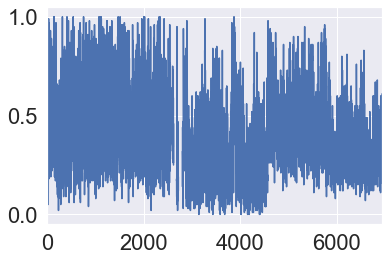

In [324]:
# look at cloudCover
series = sj_weather['cloudCover']
series.plot()

In [325]:
sj_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6937 entries, 0 to 6936
Data columns (total 30 columns):
Unnamed: 0                     6937 non-null int64
date                           6937 non-null object
apparentTemperatureHigh        6919 non-null float64
apparentTemperatureHighTime    6919 non-null float64
apparentTemperatureLow         6920 non-null float64
apparentTemperatureLowTime     6920 non-null float64
apparentTemperatureMax         6919 non-null float64
apparentTemperatureMaxTime     6919 non-null float64
apparentTemperatureMin         6919 non-null float64
apparentTemperatureMinTime     6919 non-null float64
cloudCover                     6762 non-null float64
dewPoint                       6919 non-null float64
humidity                       6919 non-null float64
moonPhase                      6921 non-null float64
pressure                       6919 non-null float64
sunriseTime                    6921 non-null float64
sunsetTime                     6921 non-null flo

In [326]:
sj_weather.head()

,Unnamed: 0,date,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,...,temperatureLowTime,temperatureMax,temperatureMaxTime,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,windBearing,windSpeed
0,0,1989-05-01 04:00:00,88.20,610048800.0,74.07,610095600.0,88.20,610048800.0,74.36,610009200.0,...,610095600.0,85.90,610048800.0,72.95,610009200.0,609998400.0,6.0,610038000.0,110.0,10.32
1,1,1989-05-02 04:00:00,88.19,610131600.0,74.07,610192800.0,88.19,610131600.0,74.07,610095600.0,...,610182000.0,83.91,610131600.0,72.95,610095600.0,610084800.0,10.0,610128000.0,101.0,8.98
2,2,1989-05-03 04:00:00,88.19,610221600.0,73.02,610279200.0,88.19,610221600.0,74.07,610192800.0,...,610268400.0,83.91,610221600.0,72.95,610182000.0,610171200.0,10.0,610214400.0,105.0,8.69
3,3,1989-05-04 04:00:00,87.50,610286400.0,73.15,610365600.0,87.50,610286400.0,73.02,610279200.0,...,610365600.0,82.86,610286400.0,71.85,610268400.0,610257600.0,10.0,610304400.0,107.0,8.18
4,4,1989-05-05 04:00:00,87.67,610390800.0,72.86,610452000.0,87.67,610390800.0,73.15,610365600.0,...,610441200.0,83.91,610390800.0,71.85,610365600.0,610344000.0,10.0,610390800.0,108.0,8.93


In [327]:
iq_weather.isnull().sum()

Unnamed: 0                      0
date                            0
apparentTemperatureHigh        17
apparentTemperatureHighTime    17
apparentTemperatureLow         19
apparentTemperatureLowTime     19
apparentTemperatureMax         11
apparentTemperatureMaxTime     11
apparentTemperatureMin         11
apparentTemperatureMinTime     11
cloudCover                     17
dewPoint                       12
humidity                       12
moonPhase                       6
sunriseTime                     6
sunsetTime                      6
temperatureHigh                17
temperatureHighTime            17
temperatureLow                 19
temperatureLowTime             19
temperatureMax                 11
temperatureMaxTime             11
temperatureMin                 11
temperatureMinTime             11
time                            6
uvIndex                         6
uvIndexTime                     6
windBearing                    84
windSpeed                      39
dtype: int64

In [328]:
iq_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 29 columns):
Unnamed: 0                     4020 non-null int64
date                           4020 non-null object
apparentTemperatureHigh        4003 non-null float64
apparentTemperatureHighTime    4003 non-null float64
apparentTemperatureLow         4001 non-null float64
apparentTemperatureLowTime     4001 non-null float64
apparentTemperatureMax         4009 non-null float64
apparentTemperatureMaxTime     4009 non-null float64
apparentTemperatureMin         4009 non-null float64
apparentTemperatureMinTime     4009 non-null float64
cloudCover                     4003 non-null float64
dewPoint                       4008 non-null float64
humidity                       4008 non-null float64
moonPhase                      4014 non-null float64
sunriseTime                    4014 non-null float64
sunsetTime                     4014 non-null float64
temperatureHigh                4003 non-null flo

In [330]:
iq_weather.head()

,Unnamed: 0,date,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,...,temperatureLowTime,temperatureMax,temperatureMaxTime,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,windBearing,windSpeed
0,0,1999-06-30 05:00:00,97.84,930769200.0,72.93,930816000.0,97.84,930769200.0,71.23,930736800.0,...,930816000.0,87.86,930769200.0,69.85,930736800.0,930718800.0,5.0,930762000.0,270.0,0.67
1,1,1999-07-01 05:00:00,94.25,930855600.0,71.23,930902400.0,94.25,930855600.0,72.93,930816000.0,...,930902400.0,84.25,930855600.0,71.65,930816000.0,930805200.0,5.0,930844800.0,291.0,1.23
2,2,1999-07-02 05:00:00,100.01,930949200.0,73.21,930992400.0,100.01,930949200.0,71.23,930902400.0,...,930992400.0,87.86,930949200.0,69.85,930902400.0,930891600.0,5.0,930942000.0,288.0,0.98
3,3,1999-07-03 05:00:00,100.01,931028400.0,74.89,931071600.0,100.01,931028400.0,73.21,930992400.0,...,931071600.0,87.86,931028400.0,71.65,930992400.0,930978000.0,7.0,931021200.0,256.0,1.46
4,4,1999-07-04 05:00:00,97.21,931114800.0,73.21,931168800.0,97.21,931114800.0,74.89,931071600.0,...,931168800.0,86.04,931111200.0,73.42,931071600.0,931064400.0,7.0,931107600.0,45.0,1.19


In [331]:
# convert date columns to datetime

sj_weather['date'] = pd.to_datetime(sj_weather['date'])
iq_weather['date'] = pd.to_datetime(iq_weather['date'])

In [332]:
# given the small amount of records with missing values, I filled all values with the mean for the column

# function to fill all missing values with the mean for each factor

def fill_mean(dataframe):
    for i, col in enumerate(dataframe):
        if col != 'date':
            dataframe[col].fillna(dataframe[col].mean(), inplace=True)

In [333]:
fill_mean(sj_weather)

# check result
sj_weather.isnull().sum()


Unnamed: 0                     0
date                           0
apparentTemperatureHigh        0
apparentTemperatureHighTime    0
apparentTemperatureLow         0
apparentTemperatureLowTime     0
apparentTemperatureMax         0
apparentTemperatureMaxTime     0
apparentTemperatureMin         0
apparentTemperatureMinTime     0
cloudCover                     0
dewPoint                       0
humidity                       0
moonPhase                      0
pressure                       0
sunriseTime                    0
sunsetTime                     0
temperatureHigh                0
temperatureHighTime            0
temperatureLow                 0
temperatureLowTime             0
temperatureMax                 0
temperatureMaxTime             0
temperatureMin                 0
temperatureMinTime             0
time                           0
uvIndex                        0
uvIndexTime                    0
windBearing                    0
windSpeed                      0
dtype: int

In [334]:
fill_mean(iq_weather)

# check result
iq_weather.isnull().sum()


Unnamed: 0                     0
date                           0
apparentTemperatureHigh        0
apparentTemperatureHighTime    0
apparentTemperatureLow         0
apparentTemperatureLowTime     0
apparentTemperatureMax         0
apparentTemperatureMaxTime     0
apparentTemperatureMin         0
apparentTemperatureMinTime     0
cloudCover                     0
dewPoint                       0
humidity                       0
moonPhase                      0
sunriseTime                    0
sunsetTime                     0
temperatureHigh                0
temperatureHighTime            0
temperatureLow                 0
temperatureLowTime             0
temperatureMax                 0
temperatureMaxTime             0
temperatureMin                 0
temperatureMinTime             0
time                           0
uvIndex                        0
uvIndexTime                    0
windBearing                    0
windSpeed                      0
dtype: int64

In [336]:
# remove the duplicate index columns
sj_weather.drop(sj_weather.columns[sj_weather.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
iq_weather.drop(iq_weather.columns[iq_weather.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [337]:
# compare columns in the darksky data with the driven data data
sj_weather.columns

Index(['date', 'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime', 'cloudCover',
       'dewPoint', 'humidity', 'moonPhase', 'pressure', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'temperatureHighTime',
       'temperatureLow', 'temperatureLowTime', 'temperatureMax',
       'temperatureMaxTime', 'temperatureMin', 'temperatureMinTime', 'time',
       'uvIndex', 'uvIndexTime', 'windBearing', 'windSpeed'],
      dtype='object')

In [338]:
df_sj.columns

Index(['week_start_date', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [339]:
iq_weather.columns

Index(['date', 'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime',
       'apparentTemperatureMax', 'apparentTemperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime', 'cloudCover',
       'dewPoint', 'humidity', 'moonPhase', 'sunriseTime', 'sunsetTime',
       'temperatureHigh', 'temperatureHighTime', 'temperatureLow',
       'temperatureLowTime', 'temperatureMax', 'temperatureMaxTime',
       'temperatureMin', 'temperatureMinTime', 'time', 'uvIndex',
       'uvIndexTime', 'windBearing', 'windSpeed'],
      dtype='object')

In [340]:
df_iq.columns

Index(['week_start_date', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

The darksky data needs to be converted into weekly, it is currently in daily format. 

In [343]:
# function to convert the daily data to weekly data

def create_weekly_dataframe(week_start_dates, daily_dataframe):
    '''
    week_start_dates: a list of pandas datetime dates
    daily_dataframe: pandas dataframe of daily weather data
    '''
    columns = daily_dataframe.columns
    rows_to_add = []
    test_count = 3

    for index, day in enumerate(week_start_dates):
#         test_count -= 1
#         if test_count > 0:

#             print('initial day {}'.format(day))
#         create a row in new_df where each column is the mean for the 7 days starting with 'day'
#         calculate the 7 days
            temp_df = pd.DataFrame()
            days = []
            for i in range (0,7):
                days.append(pd.to_datetime(day + datetime.timedelta(days=i)))

    # this is only adding 6 days at the end becuase there is a discrepancy in the start and end dates of the two data sources
    # despite the fact that they start on the same date and have the same # of records
#             print(days)
            temp_df = daily_dataframe.loc[daily_dataframe['date'].isin(days)]
#             print(temp_df)
            means = {}
            means.update(temp_df.mean(axis=0))
#             print(means)
            rows_to_add.append(means)
#             print(len(rows_to_add))
    new_df = pd.DataFrame(rows_to_add)
    new_df['week_start_date'] = week_start_dates
    cols = new_df.columns.to_list()
    cols = cols[-1:] + cols[:-1]
    new_df = new_df[cols]
    
        
    return new_df

In [344]:
# convert date column to date with no time
sj_weather['date'] = sj_weather['date'].dt.floor('d')
sj_weather['date']

0      1989-05-01
1      1989-05-02
2      1989-05-03
3      1989-05-04
4      1989-05-05
          ...    
6932   2008-04-23
6933   2008-04-24
6934   2008-04-25
6935   2008-04-26
6936   2008-04-27
Name: date, Length: 6937, dtype: datetime64[ns]

In [345]:
iq_weather['date'] = iq_weather['date'].dt.floor('d')
iq_weather['date']

0      1999-06-30
1      1999-07-01
2      1999-07-02
3      1999-07-03
4      1999-07-04
          ...    
4015   2010-06-27
4016   2010-06-28
4017   2010-06-29
4018   2010-06-30
4019   2010-07-01
Name: date, Length: 4020, dtype: datetime64[ns]

In [346]:
# make dataframes of the week start days for each city
sj_week_starts = pd.to_datetime(df_sj['week_start_date'].dt.floor('d'))
iq_week_starts = pd.to_datetime(df_iq['week_start_date'].dt.floor('d'))

In [347]:
print('length of sj_weeks in results table: {}'.format(len(sj_week_starts)))

length of sj_weeks in results table: 936


In [348]:
# check min and max in driven data data
print(sj_week_starts.min())
print(sj_week_starts.max())

1990-04-30 00:00:00
2008-04-22 00:00:00


In [349]:
# check max in darksky data
sj_weather['date'].max()

Timestamp('2008-04-27 00:00:00')

In [350]:
sj_weekly_weather = (create_weekly_dataframe(sj_week_starts, sj_weather))
sj_weekly_weather.head()

,week_start_date,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,cloudCover,...,temperatureLowTime,temperatureMax,temperatureMaxTime,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,windBearing,windSpeed
0,1990-04-30,91.875714,6.417540e+08,76.018571,6.418070e+08,91.875714,6.417540e+08,75.391429,6.417278e+08,0.497143,...,6.418054e+08,84.278571,6.417514e+08,74.400000,6.417267e+08,641707200.0,8.285714,6.417530e+08,82.714286,11.545714
1,1990-05-07,93.567143,6.423557e+08,76.300000,6.424133e+08,93.567143,6.423557e+08,76.621429,6.423326e+08,0.527143,...,6.424113e+08,85.838571,6.423557e+08,75.112857,6.423305e+08,642312000.0,9.000000,6.423542e+08,83.142857,10.152857
2,1990-05-14,91.985714,6.429657e+08,77.047143,6.430207e+08,91.985714,6.429657e+08,76.427143,6.429338e+08,0.630000,...,6.430150e+08,85.990000,6.429610e+08,75.274286,6.429291e+08,642916800.0,7.142857,6.429595e+08,94.285714,13.020000
3,1990-05-21,97.871429,6.435684e+08,77.105714,6.436239e+08,97.871429,6.435684e+08,77.082857,6.435396e+08,0.284286,...,6.436234e+08,91.281429,6.435669e+08,75.678571,6.435375e+08,643521600.0,9.714286,6.435648e+08,132.000000,9.934286
4,1990-05-28,96.167143,6.441681e+08,78.088571,6.442277e+08,96.167143,6.441681e+08,78.261429,6.441413e+08,0.422857,...,6.442272e+08,88.735714,6.441696e+08,76.531429,6.441408e+08,644126400.0,9.142857,6.441701e+08,114.571429,10.667143


In [351]:
print('length of iq_weeks in results table: {}'.format(len(iq_week_starts)))

length of iq_weeks in results table: 520


In [352]:
# check min and max in driven data data
print(iq_week_starts.min())
print(iq_week_starts.max())

2000-07-01 00:00:00
2010-06-25 00:00:00


In [353]:
# check max in darksky data
iq_weather['date'].max()

Timestamp('2010-07-01 00:00:00')

In [354]:
iq_weekly_weather = (create_weekly_dataframe(iq_week_starts, iq_weather))
iq_weekly_weather.head()

,week_start_date,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,cloudCover,...,temperatureLowTime,temperatureMax,temperatureMaxTime,temperatureMin,temperatureMinTime,time,uvIndex,uvIndexTime,windBearing,windSpeed
0,2000-07-01,96.175714,9.627367e+08,72.488571,9.627886e+08,96.175714,9.627367e+08,72.528571,9.627017e+08,0.725714,...,9.627866e+08,86.560000,9.627367e+08,71.131429,9.627002e+08,962686800.0,5.571429,9.627295e+08,149.857143,1.304286
1,2000-07-08,89.558571,9.633441e+08,69.478571,9.633857e+08,89.915714,9.633379e+08,70.244286,9.633317e+08,0.815714,...,9.633826e+08,81.672857,9.633379e+08,69.322857,9.633189e+08,963291600.0,4.857143,9.633363e+08,135.571429,2.020000
2,2000-07-15,91.012857,9.639463e+08,66.301429,9.640023e+08,91.012857,9.639463e+08,68.090000,9.639237e+08,0.722857,...,9.639982e+08,83.470000,9.639458e+08,67.292857,9.639098e+08,963896400.0,5.000000,9.639355e+08,143.571429,1.098571
3,2000-07-22,94.577143,9.645506e+08,70.845714,9.646056e+08,94.577143,9.645506e+08,66.672857,9.645285e+08,0.680000,...,9.646035e+08,85.281429,9.645495e+08,65.854286,9.645269e+08,964501200.0,5.714286,9.645444e+08,139.285714,1.368571
4,2000-07-29,100.587143,9.651549e+08,71.708571,9.652104e+08,100.587143,9.651549e+08,71.651429,9.651333e+08,0.728571,...,9.652053e+08,88.362857,9.651549e+08,70.562857,9.651286e+08,965106000.0,6.000000,9.651518e+08,189.571429,1.444286


## Summary of the four datasets prior to concatenation
* sj_weekly_weather - this is the darksky data for San Jose - 936 records
* iq_weekly_weather - this is the darksky data for Iquitos - 520 records
* df_sj - this is the drivendata data for San Jose - 936 records
* df_iq - this is the drivendata date for Iquitos - 520 records

All these dataframes share the same week_start_date values, which is pandas datetime object

The labels datasets are:
* sj_train_labels - 936 records
* iq_train_labels - 520 records

labels dataframes have these columns: 'year', 'weekofyear', 'total_cases'

Each dataset for a city has the same index.

In [4]:
# create the comnbined datasets for each city

def add_columns(df1, df2):
    '''
    df1, df2: two dataframes with matching indexes
    adds the columns in df2 to df1
    '''
    new_df = pd.concat([df1,df2], axis=1)
#     new_df = df1.copy()
#     columns = df2.columns
#     for column in columns:
# #         print(column)
#         data = df2[:,column]
#         new_df[column] = data
    return new_df

In [356]:
# remove "week_start_date" from one of the datrames for each city to prevent duplication
sj_weekly_weather.drop('week_start_date', axis=1, inplace=True)
iq_weekly_weather.drop('week_start_date', axis=1, inplace=True)

In [357]:
# create the combined dataframe
sj_combined = add_columns(df_sj, sj_weekly_weather)
iq_combined = add_columns(df_iq, iq_weekly_weather)

In [358]:
# check the output
sj_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 51 columns):
week_start_date                          936 non-null datetime64[ns]
year                                     936 non-null int64
weekofyear                               936 non-null int64
ndvi_ne                                  936 non-null float64
ndvi_nw                                  936 non-null float64
ndvi_se                                  936 non-null float64
ndvi_sw                                  936 non-null float64
precipitation_amt_mm                     936 non-null float64
reanalysis_air_temp_k                    936 non-null float64
reanalysis_avg_temp_k                    936 non-null float64
reanalysis_dew_point_temp_k              936 non-null float64
reanalysis_max_air_temp_k                936 non-null float64
reanalysis_min_air_temp_k                936 non-null float64
reanalysis_precip_amt_kg_per_m2          936 non-null float64
reanalysis_relative_humi

In [359]:
iq_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 50 columns):
week_start_date                          520 non-null datetime64[ns]
year                                     520 non-null int64
weekofyear                               520 non-null int64
ndvi_ne                                  520 non-null float64
ndvi_nw                                  520 non-null float64
ndvi_se                                  520 non-null float64
ndvi_sw                                  520 non-null float64
precipitation_amt_mm                     520 non-null float64
reanalysis_air_temp_k                    520 non-null float64
reanalysis_avg_temp_k                    520 non-null float64
reanalysis_dew_point_temp_k              520 non-null float64
reanalysis_max_air_temp_k                520 non-null float64
reanalysis_min_air_temp_k                520 non-null float64
reanalysis_precip_amt_kg_per_m2          520 non-null float64
reanalysis_relative_humi

In [361]:
# add the target variable to each dataset
sj_combined['total_cases'] = sj_train_labels['total_cases']
iq_combined['total_cases'] = iq_train_labels['total_cases']

In [362]:
# drop the useless columns
sj_combined.drop(['year', 'weekofyear'], axis=1, inplace=True)
iq_combined.drop(['year', 'weekofyear'], axis=1, inplace=True)

# Test models on the combined datasets

## San Juan combined tests

Dataset name: sj_combined
Lookback window periods: 4
Training proportion: 0.87
Dropout proportion: 0.5
last epoch loss: 0.047544803553157385
last epoch val_loss: 0.06785575972228754


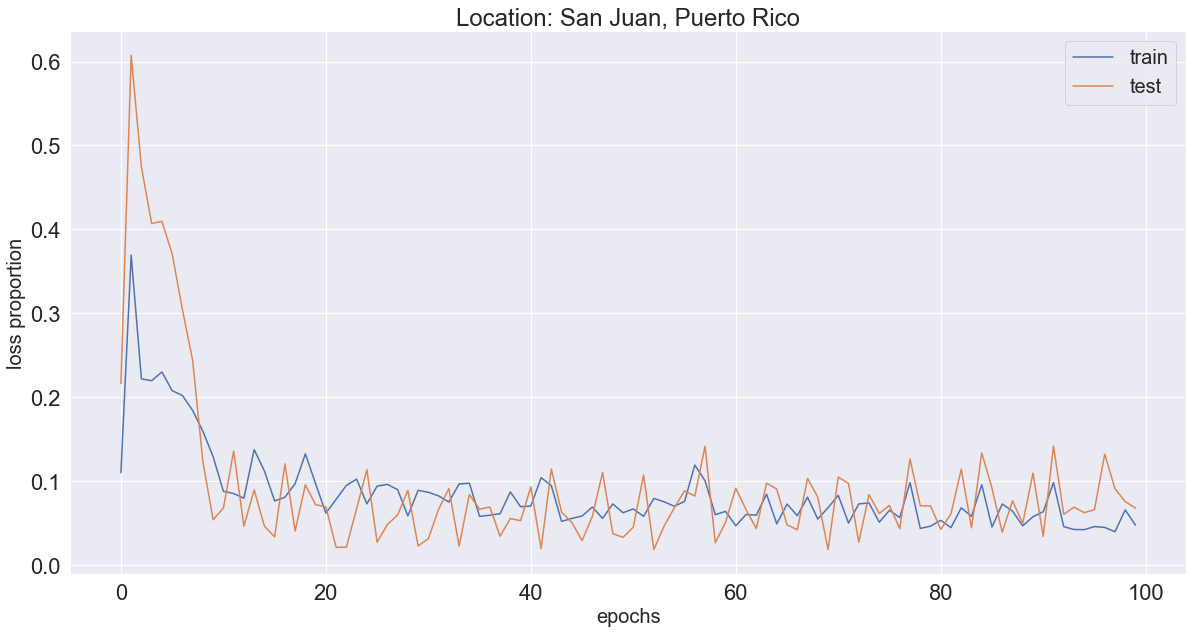

In [368]:
# for reference
# run_lstm(dataset_in, dataset_name_string, chart_title, start_col, end_col, 
#          lookback_periods, train_proportion, dropout_proportion, epoch_count)

# this was the best performing model using the driven data data
# run_lstm(sj_final, 'sj_final', 'San Juan, Puerto Rico', 1, 23, 4, .87, .5, 100)
# last epoch val_loss: 0.015283949489964813

# San Juan
run_lstm(sj_combined, 'sj_combined', 'San Juan, Puerto Rico', 1, 23, 4, .87, .5, 100)

Dataset name: sj_combined
Lookback window periods: 3
Training proportion: 0.87
Dropout proportion: 0.5
last epoch loss: 0.04462049229003939
last epoch val_loss: 0.06636793679389798


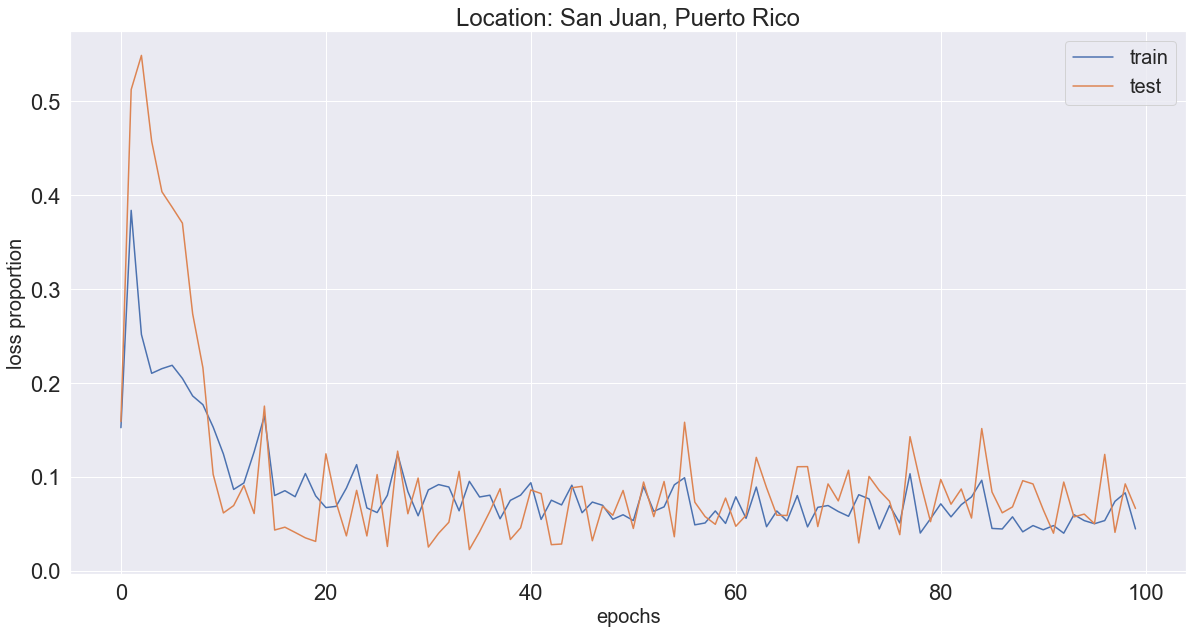

In [370]:
# try reducing the lookback periods to 3
run_lstm(sj_combined, 'sj_combined', 'San Juan, Puerto Rico', 1, 23, 3, .87, .5, 100)

Dataset name: sj_combined
Lookback window periods: 2
Training proportion: 0.87
Dropout proportion: 0.5
last epoch loss: 0.04040273992812692
last epoch val_loss: 0.052294382611747646


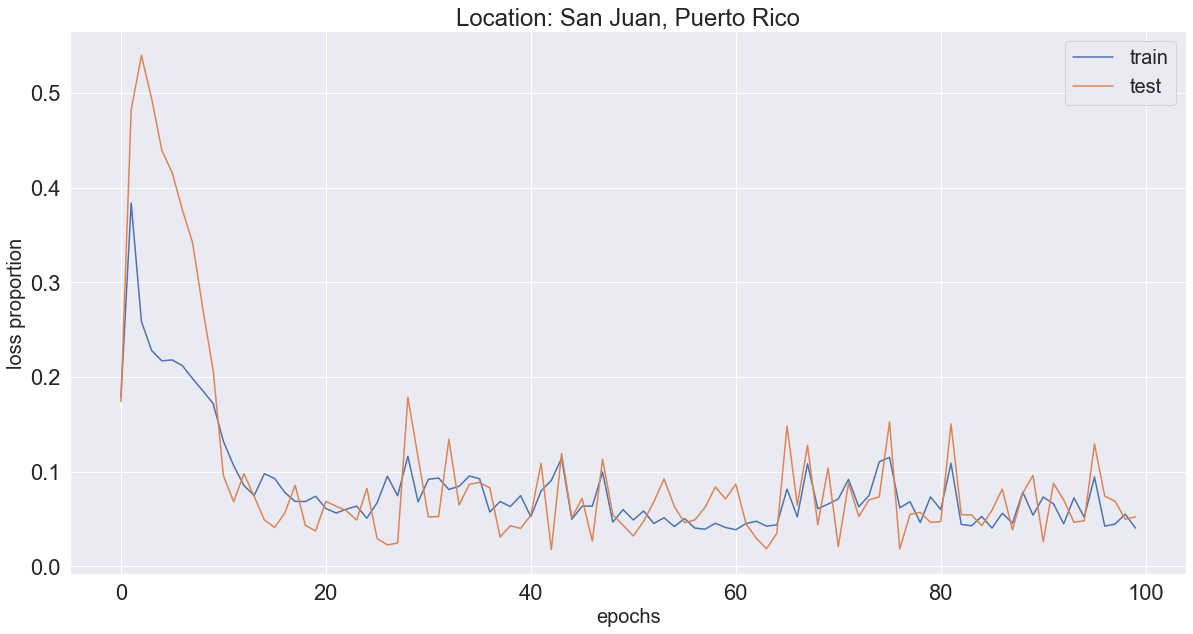

In [371]:
# try reducing the lookback periods to 2
run_lstm(sj_combined, 'sj_combined', 'San Juan, Puerto Rico', 1, 23, 2, .87, .5, 100)

Dataset name: sj_combined
Lookback window periods: 1
Training proportion: 0.87
Dropout proportion: 0.5
last epoch loss: 0.05049615863339488
last epoch val_loss: 0.04251696627403869


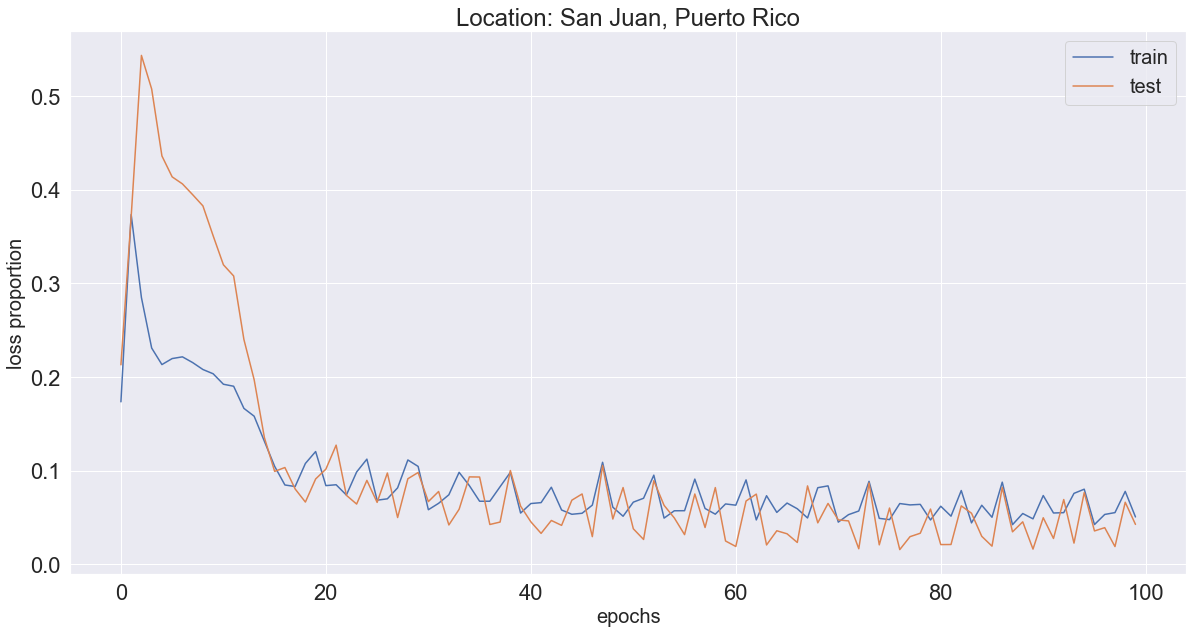

In [372]:
# try reducing the lookback periods to 1
run_lstm(sj_combined, 'sj_combined', 'San Juan, Puerto Rico', 1, 23, 1, .87, .5, 100)

## Iquitos combined models

Dataset name: iq_combined
Lookback window periods: 4
Training proportion: 0.79
Dropout proportion: 0.4
last epoch loss: 0.03683801246143383
last epoch val_loss: 0.09416390497476683


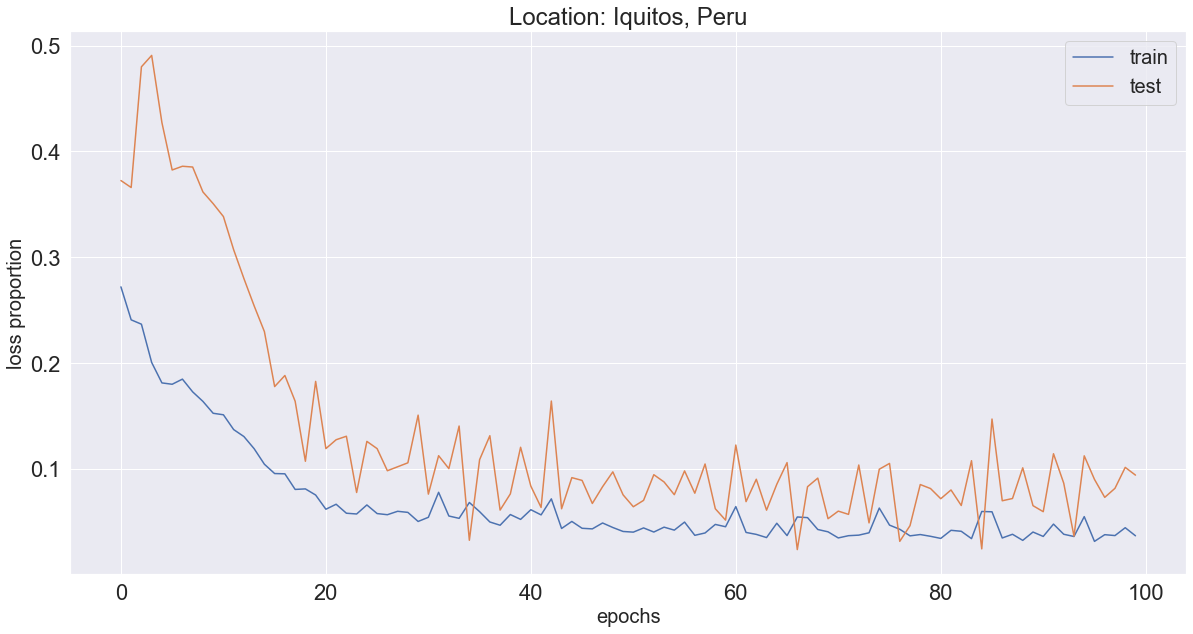

In [373]:
# for reference
# run_lstm(dataset_in, dataset_name_string, chart_title, start_col, end_col, 
#          lookback_periods, train_proportion, dropout_proportion, epoch_count)

# this was the best performing model using the driven data data
# run_lstm(iq_final, "iq_final", "Iquitos, Peru", 1, 23, 1, .79, .4, 100)
# last epoch val_loss: 0.032643817143019185


# Iquitos
run_lstm(iq_combined, "iq_combined", "Iquitos, Peru", 1, 23, 4, .79, .4, 100)

Dataset name: iq_combined
Lookback window periods: 3
Training proportion: 0.79
Dropout proportion: 0.4
last epoch loss: 0.037938896895331496
last epoch val_loss: 0.06756912875886358


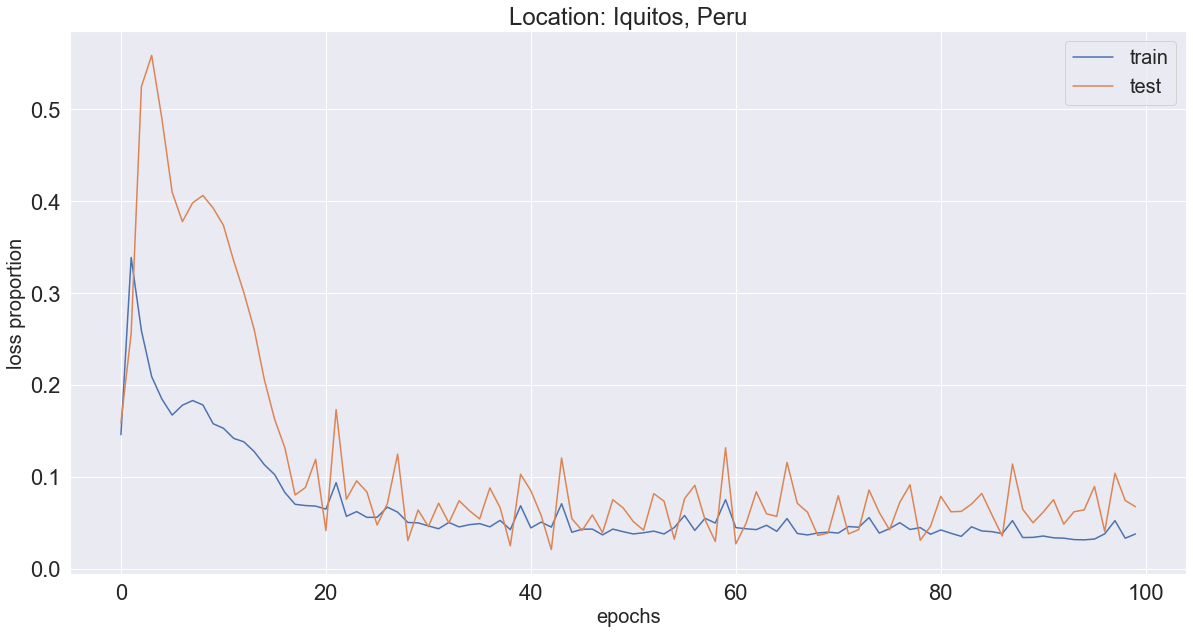

In [374]:
# reduce the lookback periods to 3
run_lstm(iq_combined, "iq_combined", "Iquitos, Peru", 1, 23, 3, .79, .4, 100)

Dataset name: iq_combined
Lookback window periods: 2
Training proportion: 0.79
Dropout proportion: 0.4
last epoch loss: 0.05028149409078444
last epoch val_loss: 0.06669424863856867


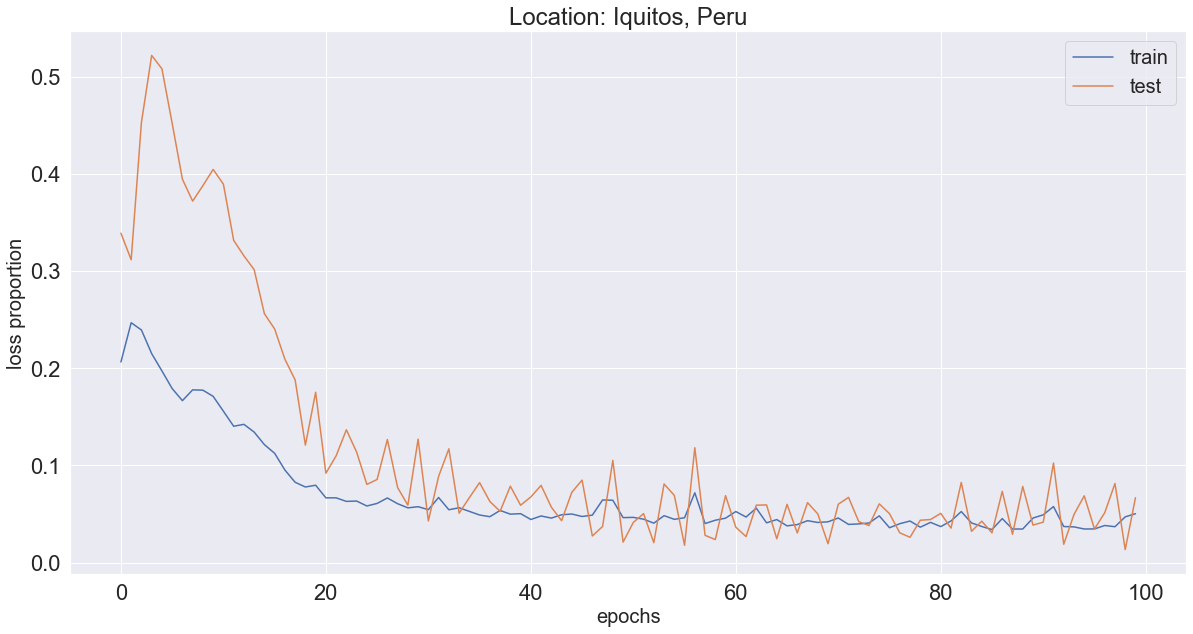

In [375]:
# reduce the lookback periods to 2
run_lstm(iq_combined, "iq_combined", "Iquitos, Peru", 1, 23, 2, .79, .4, 100)

Dataset name: iq_combined
Lookback window periods: 1
Training proportion: 0.79
Dropout proportion: 0.4
last epoch loss: 0.03366774306064699
last epoch val_loss: 0.043162075751418366


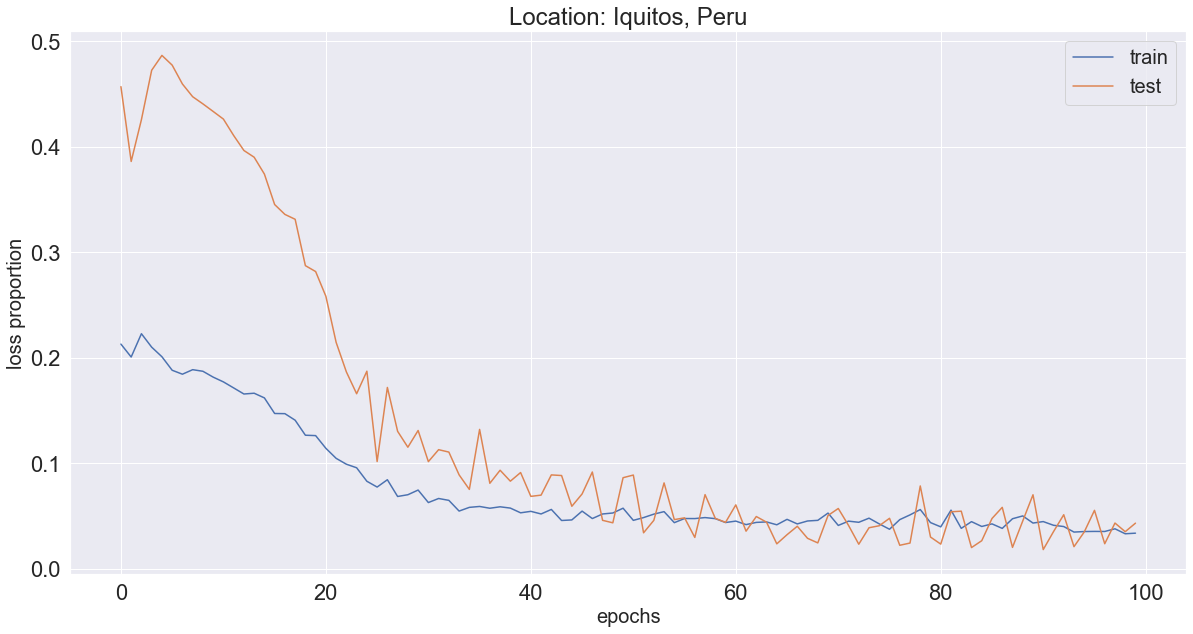

In [376]:
# reduce the lookback periods to 1
run_lstm(iq_combined, "iq_combined", "Iquitos, Peru", 1, 23, 1, .79, .4, 100)

Dataset name: iq_combined
Lookback window periods: 1
Training proportion: 0.79
Dropout proportion: 0.5
last epoch loss: 0.04827892405957711
last epoch val_loss: 0.02613847644640765


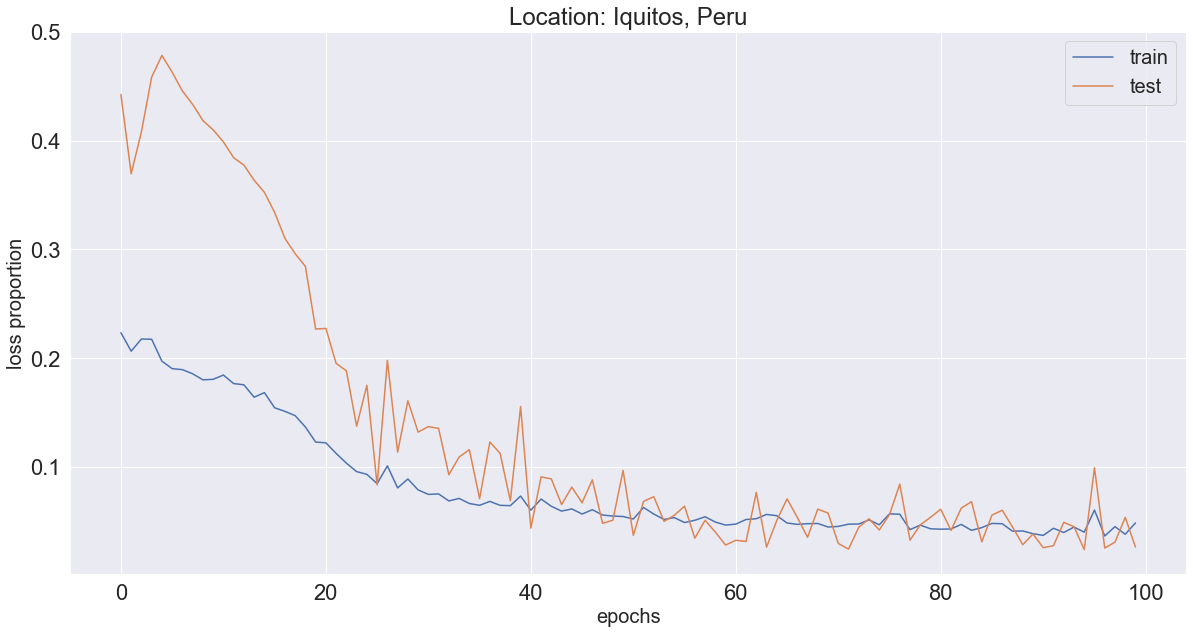

In [378]:
# increase the dropout probability to 0.5
run_lstm(iq_combined, "iq_combined", "Iquitos, Peru", 1, 23, 1, .79, .5, 100)

The model directly above performed better than the best model using only the DrivenData data.

# Notes on best performing models

A Keras Sequential model with 4 layers was used: 
    
    * model.add(LSTM(103, input_shape=(train_X.shape[1], train_X.shape[2])))
    * model.add(Dropout(dropout_proportion))
    * model.add(Dense(50, activation='relu'))
    * model.add(Dense(1))

And was compiled as follows:

    * model.compile(loss='mae', optimizer='adam')





For San Juan, Puerto Rico, the best results were obtained using only the data from DrivenData and with the following hyperparameters:
    * Loockback periods:  4 weeks
    * Trained on the first 87% of the weekly data
    * Dropout layer with a probability of 0.5



For Iquitos, Peru, the best results were obtained using the combined data from DrivenData and DarkSky and with the following hyperparameters:
    * Loockback periods:  1 week
    * Trained on the first 79% of the weekly data
    * Dropout layer with a probability of 0.5


## Sample of json object returned from the darksky api

In [ ]:
# save this example of the json object returned by the darksky api

# {
#     "latitude": 18.4653,
#     "longitude": -66.1167,
#     "timezone": "America/Puerto_Rico",
#     "daily": {
#         "data": [
#             {
#                 "time": 609998400,
#                 "summary": "Drizzle in the morning.",
#                 "icon": "rain",
#                 "sunriseTime": 610019894,
#                 "sunsetTime": 610066033,
#                 "moonPhase": 0.87,
#                 "precipIntensity": 0.001,
#                 "precipIntensityMax": 0.0118,
#                 "precipIntensityMaxTime": 610005600,
#                 "precipProbability": 1,
#                 "precipType": "rain",
#                 "temperatureHigh": 85.9,
#                 "temperatureHighTime": 610048800,
#                 "temperatureLow": 72.95,
#                 "temperatureLowTime": 610095600,
#                 "apparentTemperatureHigh": 88.2,
#                 "apparentTemperatureHighTime": 610048800,
#                 "apparentTemperatureLow": 74.07,
#                 "apparentTemperatureLowTime": 610095600,
#                 "dewPoint": 70.15,
#                 "humidity": 0.77,
#                 "pressure": 1017,
#                 "windSpeed": 10.32,
#                 "windBearing": 110,
#                 "cloudCover": 0.41,
#                 "uvIndex": 6,
#                 "uvIndexTime": 610038000,
#                 "temperatureMin": 72.95,
#                 "temperatureMinTime": 610009200,
#                 "temperatureMax": 85.9,
#                 "temperatureMaxTime": 610048800,
#                 "apparentTemperatureMin": 74.36,
#                 "apparentTemperatureMinTime": 610009200,
#                 "apparentTemperatureMax": 88.2,
#                 "apparentTemperatureMaxTime": 610048800
#             }
#         ]
#     },
#     "offset": -4
# }